# H1C IDR 3.2 Validation Power Spectra: Epoch 1

Josh Dillon (adapted from the [work of Nick Kern](https://github.com/HERA-Team/H1C_IDR2/blob/master/notebooks/pspec_progress/power_spectrum_integration.ipynb)).

## Settings

In [1]:
prefix = '' # append this string to the front of all filenames
figures_folder = 'figures' # where to save resultant figures
results_folder = 'results_files' # where to save final Delta^2 uvpspec objects
import os
if not os.path.exists(figures_folder):
    os.makedirs(figures_folder)
if not os.path.exists(results_folder):
    os.makedirs(results_folder)    

In [2]:
# file containing final per-baseline power spectra 
df = '/lustre/aoc/projects/hera/Validation/test-4.1.0/LSTBIN/epoch_1/pspec/pspec.grp1.of1.PXTK.h5'

# file containing matching power spectra without cross-talk subtraction
no_xtalk_df = '/lustre/aoc/projects/hera/Validation/test-4.1.0/LSTBIN/epoch_1/pspec/pspec.grp1.of1.PTK.h5'

In [3]:
# overall signal loss corrections, per band
abscal_bias = {0: 1.0, 1: 1.0}  # this goes into data and errors
other_bias = {0: 1.043, 1: 1.048}  # this goes into just data

In [4]:
# LST ranges of fields
lstcuts = [(-2.5, 0), # Field A
           (0.75, 2.75), # Field B
           (4, 6.25), # Field C
           (6.25, 9.25), # Field D
           (9.25, 14.75),  # Field E
          ]

lst_colors = ['limegreen', 'gold', 'cyan', 'deeppink', 'mediumorchid', 'aquamarine']

In [5]:
# Parameters for |SNR| analysis
SNR_fields_to_use = [1, 2, 3] # (i.e. B, C, D): these are the fields to look for excess systematics
xtalk_dly_min = 800 # ns
xtalk_dly_max = 1500 # ns
high_dly_diff = 2000 # ns (amount to increase above delays for comparison to noise-dominated delays)

# Parameters of |SNR| cuts
auto_xtalk_snr_cut = 1.5

In [6]:
# Spherical Binning Cuts
wedge_buff_ns = 300
sph_minimum_ew_distance = 15
sph_minimum_bl_length = 0
sph_maximum_bl_length = 1e100

# Spherical Binning Parameters
dk_multiplier = 2.0 # the size of each spherical k bin (Delta k) when multiplied by the natural k_para spacing
k_start_multiplied = .75 # the center of first spherical k bin in units of Delta k

## Imports

In [7]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker
import glob
import warnings
import hera_cal as hc
import hera_pspec as hp
from pyuvdata import UVBeam, UVData, UVCal, UVFlag, utils as uvutils
import pyuvdata
from scipy import stats, signal, interpolate
import scipy
from memory_profiler import memory_usage
import copy
import matplotlib.gridspec as gridspec
from astropy import constants, units, coordinates as crd
from astropy.time import Time
import uvtools as uvt
import pandas as pd
from IPython.core.display import display, HTML
import git  # pip install gitpython
import simpleqe as sqe

/users/jsdillon/lustre/tmp/ipykernel_7224/2657920419.py:21: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [8]:
from matplotlib import rc
rc('font',**{'family':'serif', 'serif':['times new roman'], 'size': 18})
rc('text', usetex=True)

In [9]:
# add utils.py helper IO and plotting functions to path
import sys
import imp
sys.path.insert(1, "../")
import utils
imp.reload(utils);

/users/jsdillon/lustre/tmp/ipykernel_7224/1913162407.py:3: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp


In [10]:
# print git hashes and versions
for module in [pyuvdata, hp, hc]:
    vs = getattr(module, "__version__", None)
    try:
        gh = git.Repo('/'.join(module.__path__[0].split('/')[:-1])).head.commit.hexsha
    except:
        if hasattr(module, "version"):
            gh = module.version.git_hash
        else:
            gh = 'None'
    print("Module {:<11}....\tVersion {:<7}.......\tGit {:<20}".format(module.__name__, vs[:7], gh[:20]))

Module pyuvdata   ....	Version 2.2.7.d.......	Git None                
Module hera_pspec ....	Version 0.3.0  .......	Git 00ab817e332347ca7566
Module hera_cal   ....	Version 3.0    .......	Git c4b91447be091a0195e9


# Show Flags and Bands

In [11]:
spw_ranges = [[176, 340], [535, 697]] # these can be found in the pspec histories
hand_flag_files = glob.glob('/lustre/aoc/projects/hera/Validation/test-4.1.0/LSTBIN/all_epochs/*hand_flags.h5')
hand_flag_files = sorted(hand_flag_files, key=lambda f: np.mean(UVFlag(f).time_array))
uvf = UVFlag(hand_flag_files)
lsts = np.unwrap(uvf.lst_array) * 12 / np.pi
while np.max(lsts) > 24:
    lsts -= 24
freqs = uvf.freq_array / 1e6

## Band definitions

Show where the bands fall relative to the flagging pattern.

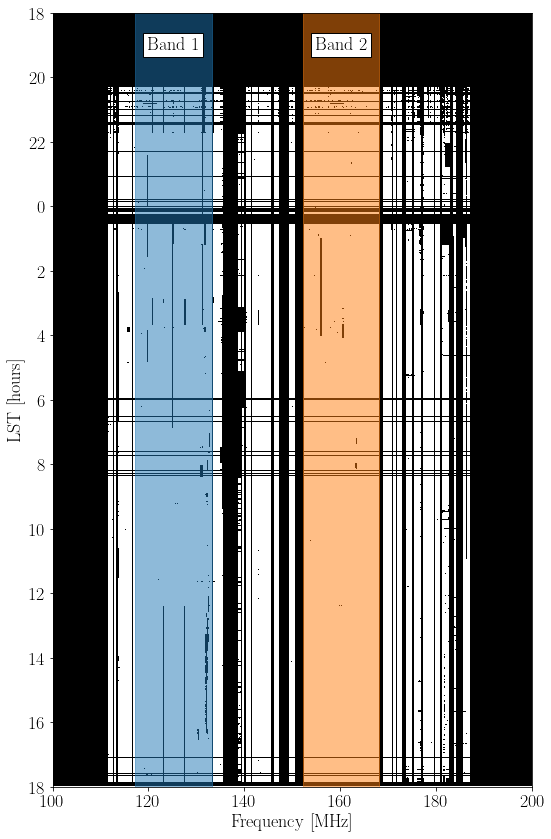

In [12]:
plt.figure(figsize=(8,12))
plt.imshow(uvf.flag_array.squeeze(), aspect='auto', interpolation='none', cmap='binary',
           extent=[freqs[0], freqs[-1], lsts[-1], lsts[0]])

for band, spwr, color in zip([1, 2], spw_ranges, ['C0', 'C1']):
    plt.axvspan(freqs[spwr[0]], freqs[spwr[1]], color=color, alpha=.5)
    plt.text(np.mean([freqs[spwr[0]], freqs[spwr[1]]]), -5, f'Band {band}', 
             bbox=dict(facecolor='w', alpha=1), va='center', ha='center')

plt.yticks(ticks=np.arange(-6, 20, 2), labels=(np.arange(-6, 20, 2) % 24));
plt.xticks(np.linspace(100, 200, 6))
plt.xlabel('Frequency [MHz]')
plt.ylabel('LST [hours]')
plt.tight_layout()
plt.savefig(f'{figures_folder}/{prefix}flag_waterfall.pdf', dpi=200)

## Flag occupancy and per-band tapers 

This reproduces Figure 12 in [HERA Collaboration (2021a)](https://arxiv.org/abs/2108.02263).

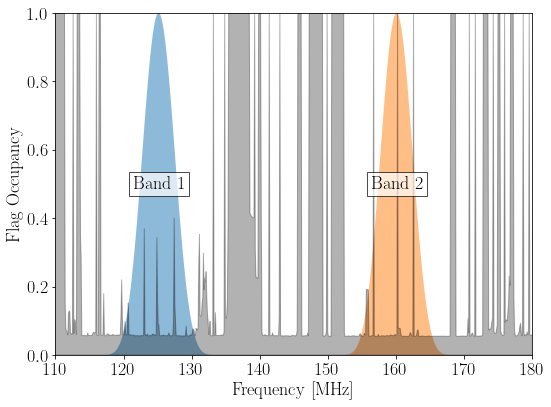

In [13]:
plt.figure(figsize=(8,6))
unflagged_time_inds = np.arange(uvf.flag_array.shape[0])[~np.all(uvf.flag_array.squeeze(), axis=1)]
flag_time_subset = uvf.flag_array[np.min(unflagged_time_inds):(np.max(unflagged_time_inds) + 1), :, 0]

for band, spwr, color in zip([1, 2], spw_ranges, ['C0', 'C1']):
    bh = scipy.signal.blackmanharris(spwr[1]-spwr[0])
    plt.fill_between(freqs[spwr[0]:spwr[1]], bh,  alpha=.5)
    plt.text(np.mean([freqs[spwr[0]], freqs[spwr[1]]]), .5, f'Band {band}', 
             bbox=dict(facecolor='w', alpha=.7), va='center', ha='center')
    

plt.fill_between(freqs, np.mean(flag_time_subset, axis=0), alpha=.3, color='k', edgecolor='k', linewidth=1)
plt.ylabel('Flag Occupancy')
plt.xlabel('Frequency [MHz]')
plt.xlim([110, 180])
plt.ylim([0, 1])
plt.tight_layout()
plt.savefig(f'{figures_folder}/{prefix}flag_occupancy.pdf', dpi=200)

# Load power spectrum container

In [14]:
# load get pspec container for cross-talk subtracted files
psc = hp.container.PSpecContainer(df, keep_open=False)
uvps_xtk, lens, angs, Nblps = utils.load_red_uvps(psc, 'stokespol', proj_EW_cut=14., spws=[0, 1], polpairs=['pI'])

In [15]:
# load get pspec container for files without cross-talk subtraction
psc = hp.container.PSpecContainer(no_xtalk_df, keep_open=False)
uvps_tk, lens, angs, Nblps = utils.load_red_uvps(psc, 'stokespol', proj_EW_cut=14., spws=[0, 1], polpairs=['pI'])

In [16]:
# P_SN correction
for uvp in uvps_xtk:
    hp.utils.apply_P_SN_correction(uvp, P_SN='P_SN', P_N='P_N')

invalid value encountered in true_divide


In [17]:
# copy stats array from xtk to tk for consistency
for uvp_xtk, uvp_tk in zip(uvps_xtk, uvps_tk):
    # if foreground dependent in uvp_xtk, rename it as P_SN
    if "foreground_dependent_diag" in uvp_xtk.stats_array:
        uvp_xtk.stats_array['P_SN'] = uvp_xtk.stats_array.pop('foreground_dependent_diag')
    # ensure its real-valued: foreground_dependent_diag returns complex valued array
    for stat in uvp_xtk.stats_array:
        for spw in uvp_xtk.spw_array:
            uvp_xtk.stats_array[stat][spw] = uvp_xtk.stats_array[stat][spw].real
            nans = np.isnan(uvp_xtk.stats_array[stat][spw])
            uvp_xtk.stats_array[stat][spw][nans] = np.inf
    uvp_tk.stats_array = copy.deepcopy(uvp_xtk.stats_array)

In [18]:
pd.options.display.float_format = '{:.2f}'.format
pd.DataFrame([np.around(lens,1), angs, Nblps], index=['length [m]', 'angle [deg]', 'Nbl pairs'])

,0,1,2,3,4,5,6,7,8,9,...,87,88,89,90,91,92,93,94,95,96
length [m],15.00,25.00,25.00,29.00,29.00,29.00,39.00,39.00,39.00,39.00,...,110.00,116.00,116.00,117.00,117.00,120.00,120.00,120.00,125.00,125.00
angle [deg],0.00,30.00,150.00,0.00,60.00,120.00,19.00,41.00,139.00,161.00,...,127.00,79.00,139.00,60.00,120.00,72.00,108.00,132.00,114.00,126.00
Nbl pairs,729.00,289.00,289.00,441.00,324.00,256.00,121.00,225.00,196.00,225.00,...,4.00,1.00,1.00,1.00,4.00,1.00,1.00,1.00,1.00,1.00


In [19]:
# apply bias correction
for uvp_xtk, uvp_tk in zip(uvps_xtk, uvps_tk):
    utils.bias_correction(uvp_xtk, abscal_bias, other_bias)
    utils.bias_correction(uvp_tk, abscal_bias, other_bias)

# Initial Data Quality Checks

## Display sample baseline power spectrum

In [20]:
def find_index_of_key(key, list_of_uvps):
    '''This function figures out which UVPspec object in a list has a given key. 
    Returns None if not any of them.'''
    for i, uvp in enumerate(list_of_uvps):
        if key in uvp.get_all_keys():
            return i
    return None    

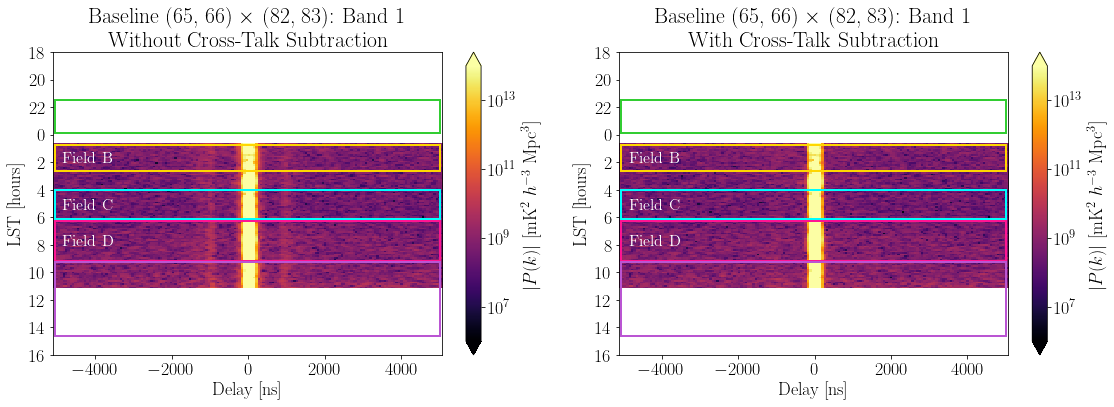

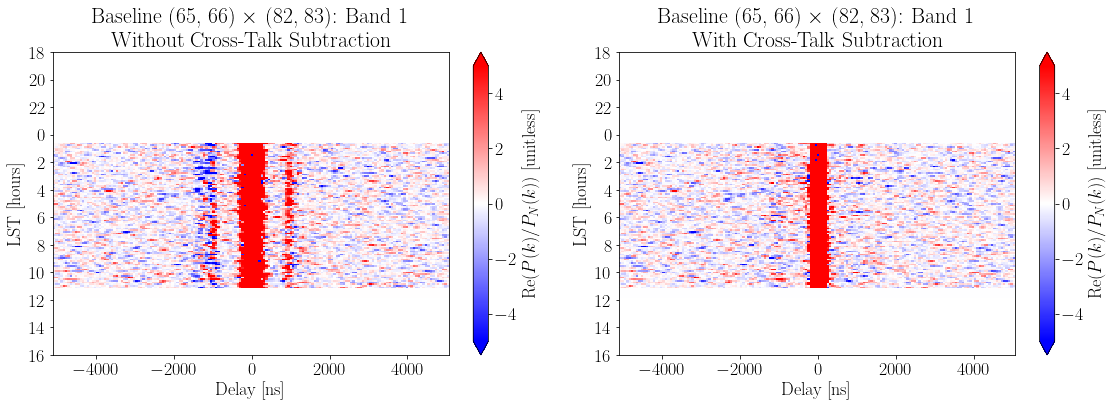

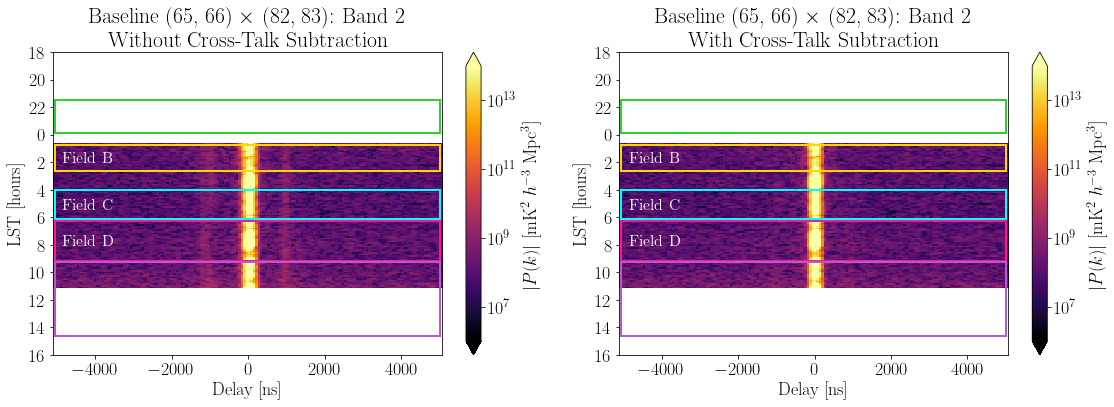

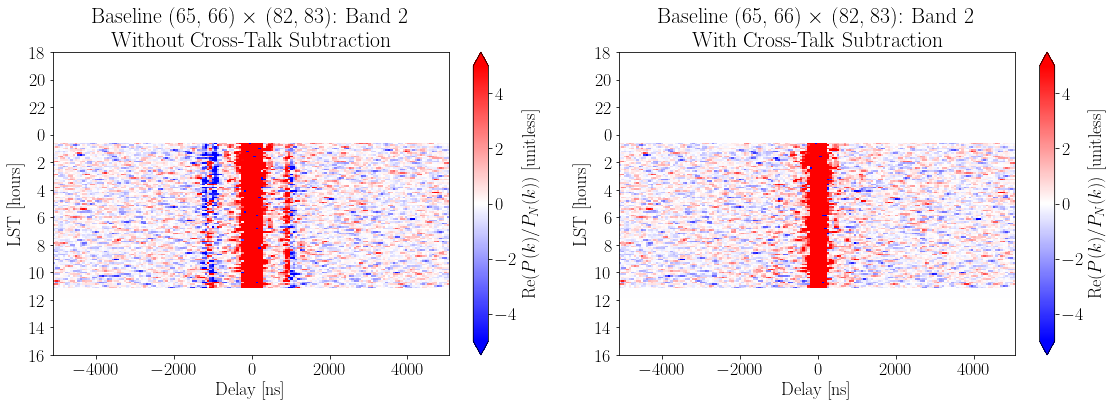

In [21]:
# Plot P(k) and SNR waterfalls for both band and a single waterfall
blp = ((65, 66), (82, 83))

for spw in range(2):
    key = (spw, blp, ('pI', 'pI'))
    ind = find_index_of_key(key, uvps_xtk)

    # construct LSTs, taking into account duplication and wrapping
    lst_indexes = np.unique(uvps_xtk[ind].lst_1_array, return_index=True)[1]
    lsts_wrapped = np.unwrap([uvps_xtk[ind].lst_avg_array[i] for i in sorted(lst_indexes)]) * 12 / np.pi
    while np.max(lsts_wrapped) > 24:
        lsts_wrapped -= 24

    dlys = np.unique(uvps_xtk[ind].dly_array)
    extent = [dlys[0]*1e9, dlys[-1]*1e9, lsts_wrapped[-1], lsts_wrapped[0]]
    
    for plt_type in ['pk', 'snr']:
        fig, axes = plt.subplots(1,2, figsize=(16,6))
        for i, ax in enumerate(axes):
            uvps = [uvps_tk, uvps_xtk][i]
            if plt_type == 'pk':
                im = ax.imshow(np.where(~np.isfinite(uvps[ind].get_stats('P_N', key)), np.nan, np.abs(uvps[ind].get_data(key))), 
                               norm=matplotlib.colors.LogNorm(vmin=1e6, vmax=1e14), 
                               aspect='auto', interpolation='none', cmap='inferno', extent=extent)
                cbar = plt.colorbar(im, ax=ax, label=r'$|P(k)|\ [{\rm mK}^2\ h^{-3}\ {\rm Mpc}^3]$', extend='both')
                for i, lc in enumerate(lstcuts):
                    r = plt.Rectangle((extent[0]*.99, lc[0]), (extent[1] - extent[0])*.99, lc[1]-lc[0]-.1, fc='None', ec=lst_colors[i], lw=2)
                    ax.add_patch(r)
                    ax.text(extent[0]*.95, np.mean(lc), f"Field {'ABCDEFGHIJ'[i]}", fontsize=16, c='w', ha='left', va='center')
                
            elif plt_type == 'snr':
                im = ax.imshow(np.real(uvps[ind].get_data(key)) / uvps[ind].get_stats('P_N', key),
                               aspect='auto', interpolation='none', extent=extent, cmap='bwr', vmin=-5, vmax=5)
                cbar = plt.colorbar(im, ax=ax, label=r'$\mbox{Re}(P(k) / P_N(k))\ [\mbox{unitless}]$', extend='both')                
                
        for i, ax in enumerate(axes):
            ax.set_xlabel('Delay [ns]')
            ax.set_ylabel('LST [hours]')
            ax.set_yticks(np.arange(-6, 18, 2))
            ax.set_yticklabels(np.arange(-6, 18, 2) % 24)
            title = f'Baseline {blp[0]} ' + r'$\times$' + f' {blp[1]}: Band {spw+1}'
            ax.set_title(title + '\n' + ['Without Cross-Talk Subtraction', 'With Cross-Talk Subtraction'][i])

        plt.tight_layout()

## Check noise and the number of samples

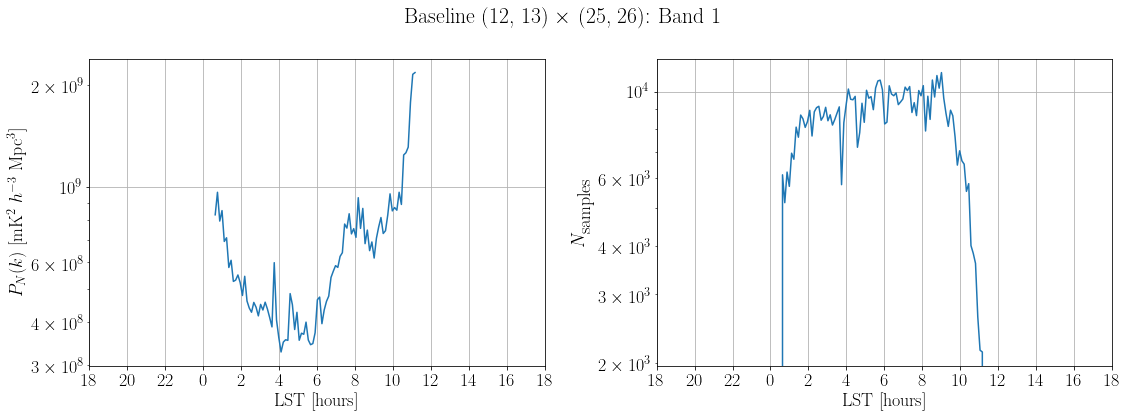

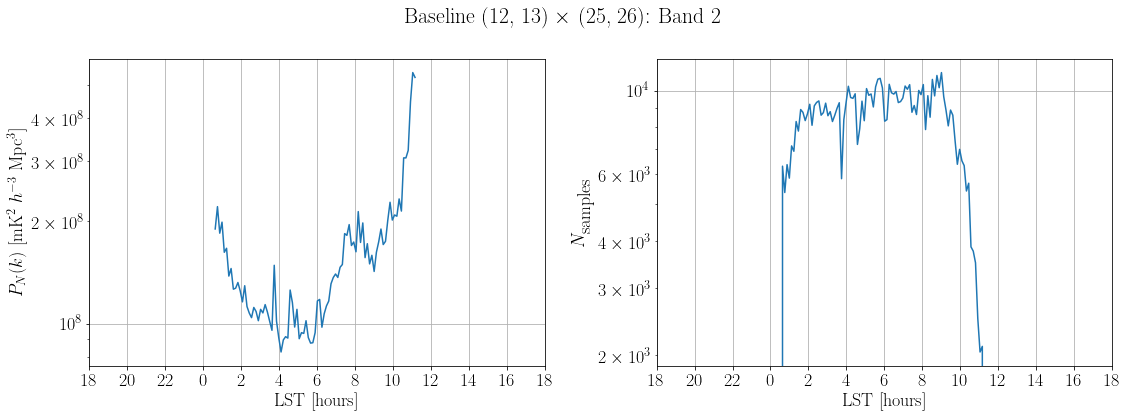

In [22]:
# Plot P(k) and SNR waterfalls for both band and a single waterfall
blp = ((12, 13), (25, 26))

for spw in range(2):
    key = (spw, blp, ('pI', 'pI'))
    ind = find_index_of_key(key, uvps_xtk)

    fig, axes = plt.subplots(1, 2, figsize=(16,6))
    for i, ax in enumerate(axes):
        if i == 0:
            ax.semilogy(lsts_wrapped, np.mean(uvps_xtk[ind].get_stats('P_N', key), axis=1))
            ax.set_ylabel(r'$P_N(k)\ [{\rm mK}^2\ h^{-3}\ {\rm Mpc}^3]$')
        else:
            ax.semilogy(lsts_wrapped, uvps_xtk[ind].get_integrations(key))#np.mean(uvps[ind].get_stats('P_N', key), axis=1))
            ax.set_ylabel(r'$N_{\mbox{samples}}$')
            
        ax.set_xlabel('LST [hours]')
        ax.set_xticks(np.arange(-6, 20, 2))
        ax.set_xticklabels(np.arange(-6, 20, 2) % 24)
        ax.grid()
    
    plt.suptitle(f'Baseline {blp[0]} ' + r'$\times$' + f' {blp[1]}: Band {spw+1}')

    plt.tight_layout()

## Look for failures of x-talk subtraction

In [23]:
# look for baseline-paris and integrations where cross-talk subtraction has sigificantly added power. Ideally, we won't find any.
fig_made = False

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    for uvp_tk, uvp_xtk in zip(uvps_tk, uvps_xtk):    
        for key in uvp_tk.get_all_keys():
            med_abs_before = np.nanmedian(np.abs(np.where(np.isfinite(uvp_tk.get_stats('P_N', key)), uvp_tk.get_data(key), np.nan)), axis=1)
            med_abs_after = np.nanmedian(np.abs(np.where(np.isfinite(uvp_xtk.get_stats('P_N', key)), uvp_xtk.get_data(key), np.nan)), axis=1)
            if np.any(med_abs_after / med_abs_before > 2):
                if not fig_made:
                    fig_made = True
                    plt.figure()
                    plt.plot(lsts_wrapped, np.ones_like(lsts_wrapped), 'k--')
                plt.plot(lsts_wrapped, med_abs_after / med_abs_before,'.-')
    if not fig_made: 
        print('No baseline pairs found with excess power in cross-talk subtracted power spectra.')

No baseline pairs found with excess power in cross-talk subtracted power spectra.


# Analysis of Residual Cross-Talk

The purpose of this section is to identify baselines with substantial residual cross-talk and flag them before further averaging.

## Compute cross-talk SNR matrices

In [24]:
# store SNRs as a function of band, delay (pos/neg/both), and whether or not cross-talk subtraction as been performed
xtalk_SNRs = {pre + func: {0:{}, 1:{}} for func in ['abs', 'pos', 'neg'] for pre in ['no_xtalk_sub_', '']}
xtalk_counts = {pre + func: {0:{}, 1:{}} for func in ['abs', 'pos', 'neg'] for pre in ['no_xtalk_sub_', '']}
high_dly_SNRs = {pre + func: {0:{}, 1:{}} for func in ['abs', 'pos', 'neg'] for pre in ['no_xtalk_sub_', '']}
high_dly_counts = {pre + func: {0:{}, 1:{}} for func in ['abs', 'pos', 'neg'] for pre in ['no_xtalk_sub_', '']}

key_to_blvecs = {}

# perform this calculation both without and with cross-talk subtraction
for x, uvps in enumerate([uvps_tk, uvps_xtk]):
    # loop over all baseline groups
    for uvp in uvps:
        blvec = np.mean(uvp.get_blpair_blvecs(), axis=0)
        
        # figure out which LSTs to use
        lst_indexes = np.unique(uvp.lst_1_array, return_index=True)[1]
        lsts_wrapped = np.unwrap([uvp.lst_avg_array[i] for i in sorted(lst_indexes)]) * 12 / np.pi
        while np.max(lsts_wrapped) > 24:
            lsts_wrapped -= 24
        to_use = np.zeros_like(lsts_wrapped, dtype=bool)
        for field in SNR_fields_to_use:
            to_use[np.logical_and(lsts_wrapped < lstcuts[field][1], lsts_wrapped >  lstcuts[field][0])] = True

        # loop over baseline pairs
        for blp in uvp.get_blpairs():
            # loop over spectral windows
            for spw in uvp.spw_array:
                key=(spw, blp, ('pI', 'pI'))
                key_to_blvecs[key] = blvec
                dlys = uvp.get_dlys(spw)

                # compute SNRs at the relevant LSTs
                S = np.real(uvp.get_data(key))
                N = np.abs(uvp.get_stats('P_N', key))
                SNR = np.where(np.isfinite(S) & np.isfinite(N), S / N, np.nan)
                snr_here = SNR[to_use]
                
                # loop over both positive and negative delays, then just positive delays, then just negative delays
                for func, fname in zip([np.abs, lambda x: x, lambda x: -x], ['abs', 'pos', 'neg']):
                    if fname == 'neg':
                        xtalk_dlys = (dlys < -xtalk_dly_min/1e9) & (dlys > -xtalk_dly_max/1e9)
                        high_dlys = (dlys < -(xtalk_dly_min + high_dly_diff)/1e9) & (dlys > -(xtalk_dly_max + high_dly_diff)/1e9)
                    else:
                        xtalk_dlys = (func(dlys) > xtalk_dly_min/1e9) & (func(dlys) < xtalk_dly_max/1e9)
                        high_dlys = (func(dlys) > (xtalk_dly_min + high_dly_diff)/1e9) & (func(dlys) < (xtalk_dly_max + high_dly_diff)/1e9)                        
                    
                    if x==0:
                        fname = 'no_xtalk_sub_' + fname
                    # compute the average SNRs at the appropriate delays
                    xtalk_SNRs[fname][spw][key] = np.nanmean(np.abs(snr_here[:, xtalk_dlys]))
                    xtalk_counts[fname][spw][key] = np.sum(np.isfinite(snr_here[:, xtalk_dlys]))
                    high_dly_SNRs[fname][spw][key] = np.nanmean(np.abs(snr_here[:, high_dlys]))
                    high_dly_counts[fname][spw][key] = np.sum(np.isfinite(snr_here[:, high_dlys]))                    

In [25]:
# organize dictionaries for scatter plots
auto_xtalk_snrs = {}
cross_xtalk_snrs = {}
auto_high_dly_snrs = {}
auto_blp1_xtalk_snrs = {}
auto_blp2_xtalk_snrs = {}
cross_bl_lens = {}
cross_blx = {}

for fname in xtalk_SNRs:
    auto_xtalk_snrs[fname] = {}
    cross_xtalk_snrs[fname] = {}
    auto_high_dly_snrs[fname] = {}    
    auto_blp1_xtalk_snrs[fname] = {}
    auto_blp2_xtalk_snrs[fname] = {}    
    cross_bl_lens[fname] = {}
    cross_blx[fname] = {}
    
    for spw in xtalk_SNRs[fname]:
        auto_xtalk_snrs[fname][spw] = np.array([])
        cross_xtalk_snrs[fname][spw] = np.array([])
        auto_high_dly_snrs[fname][spw] = np.array([])    
        auto_blp1_xtalk_snrs[fname][spw] = np.array([])
        auto_blp2_xtalk_snrs[fname][spw] = np.array([])
        cross_bl_lens[fname][spw] = np.array([])
        cross_blx[fname][spw] = np.array([])
        
        for k in sorted(list(xtalk_SNRs[fname][spw].keys())):
            blp1, blp2 = k[1]
            if blp1 == blp2:
                auto_xtalk_snrs[fname][spw] = np.append(auto_xtalk_snrs[fname][spw], xtalk_SNRs[fname][spw][k])
                auto_high_dly_snrs[fname][spw] = np.append(auto_high_dly_snrs[fname][spw], high_dly_SNRs[fname][spw][k])
            else:
                cross_xtalk_snrs[fname][spw] = np.append(cross_xtalk_snrs[fname][spw], xtalk_SNRs[fname][spw][k])
                auto_blp1_xtalk_snrs[fname][spw] = np.append(auto_blp1_xtalk_snrs[fname][spw], xtalk_SNRs[fname][spw][k[0], (blp1, blp1), k[2]])
                auto_blp2_xtalk_snrs[fname][spw] = np.append(auto_blp2_xtalk_snrs[fname][spw], xtalk_SNRs[fname][spw][k[0], (blp2, blp2), k[2]])
                cross_bl_lens[fname][spw] = np.append(cross_bl_lens[fname][spw], np.linalg.norm(key_to_blvecs[k]))
                cross_blx[fname][spw] = np.append(cross_blx[fname][spw], key_to_blvecs[k][0])

### Examine cross-talk removal efficacy, comparing cross-talk power before and after subtraction

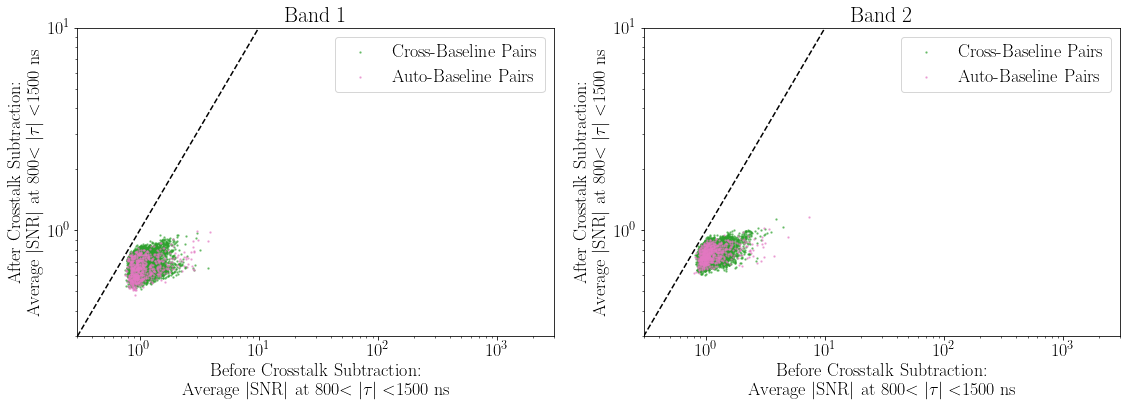

In [26]:
fig, axes = plt.subplots(1,2, figsize=(16,6))
for i, ax in enumerate(axes):
    ax.scatter(cross_xtalk_snrs['no_xtalk_sub_' + 'abs'][i], cross_xtalk_snrs['abs'][i], s=2, alpha=.5, label='Cross-Baseline Pairs', color='C2')
    ax.scatter(auto_xtalk_snrs['no_xtalk_sub_' + 'abs'][i], auto_xtalk_snrs['abs'][i], s=2, alpha=.5, label='Auto-Baseline Pairs', color='C6')

    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_ylabel('After Crosstalk Subtraction:\nAverage $|$SNR$|$ at ' + f'{xtalk_dly_min}' + '$<|\\tau| <$' + f'{xtalk_dly_max} ns')
    ax.set_xlabel('Before Crosstalk Subtraction:\nAverage $|$SNR$|$ at ' + f'{xtalk_dly_min}' + '$<|\\tau| <$' + f'{xtalk_dly_max} ns')
    ax.set_title(f'Band {i+1}')
#     ax.axhline((2/np.pi)**.5, linestyle='--', color='k')
#     ax.axvline((2/np.pi)**.5, linestyle='--', color='k')
    ax.set_xlim([.3, 3e3])
    ax.set_ylim([.3, 10])
    ax.axline((1,1), (2,2), linestyle='--', color='k')    
    
    ax.legend()
plt.tight_layout()
plt.savefig(f'{figures_folder}/{prefix}crosstalk_subtraction_efficiency_scatter.png', dpi=200)

### Examine residual cross-talk matrices

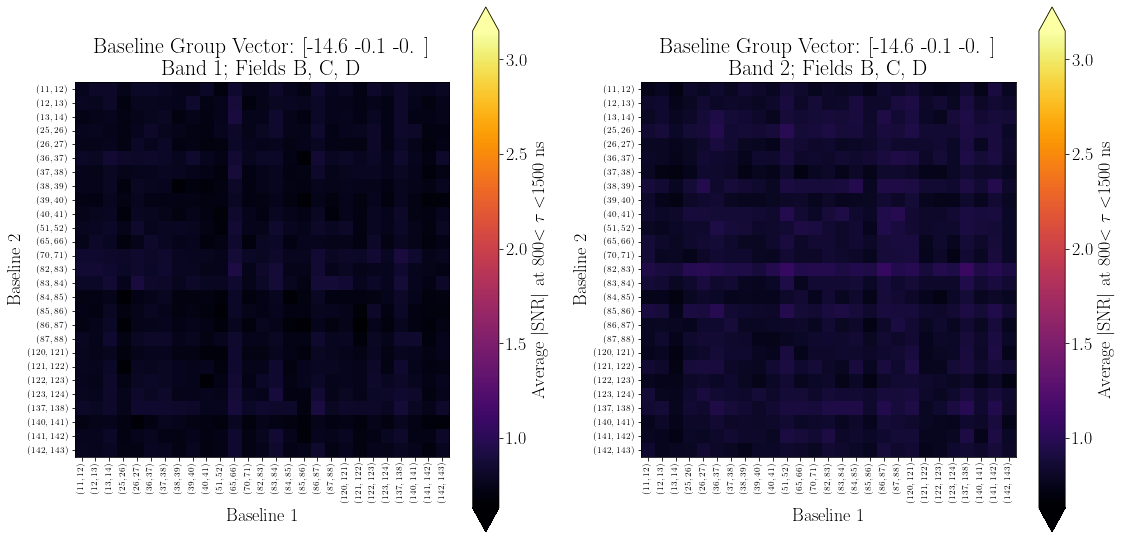

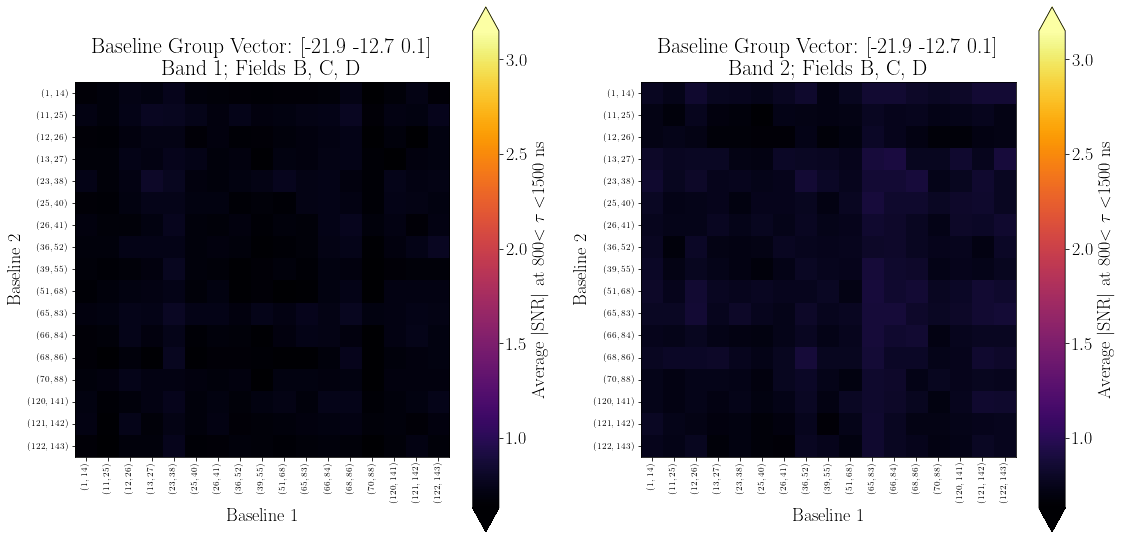

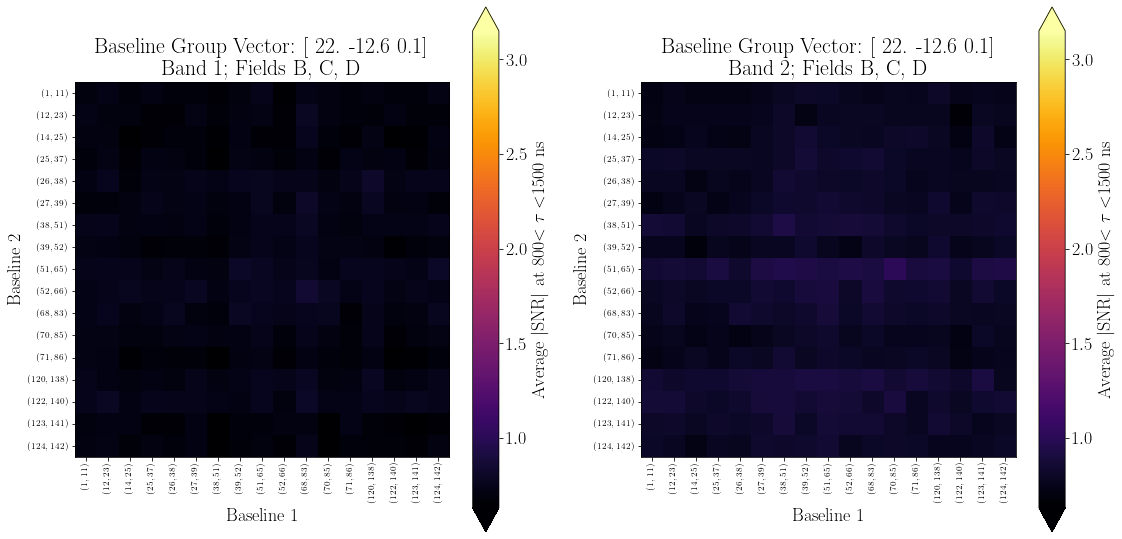

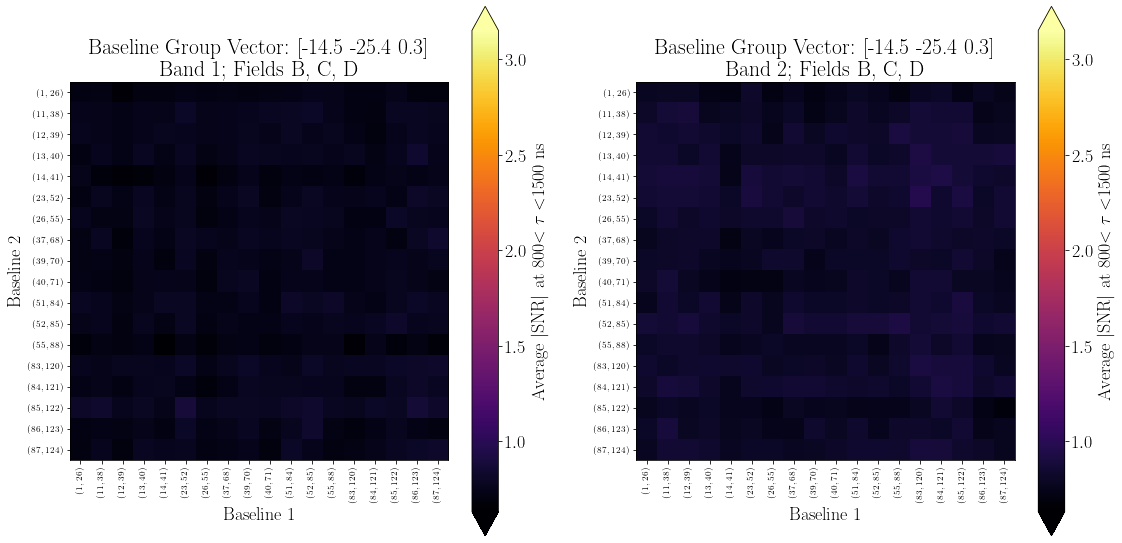

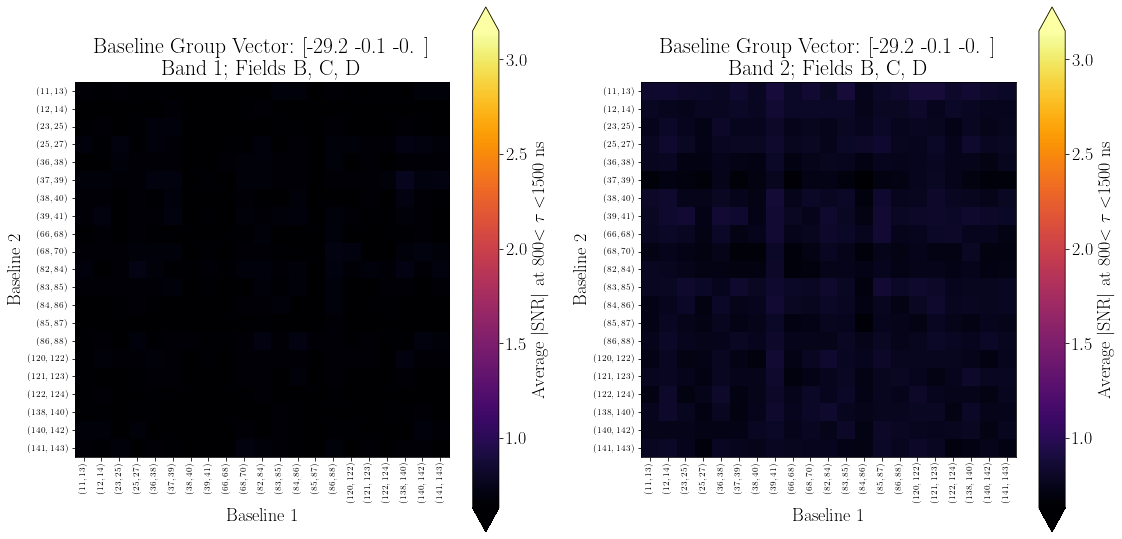

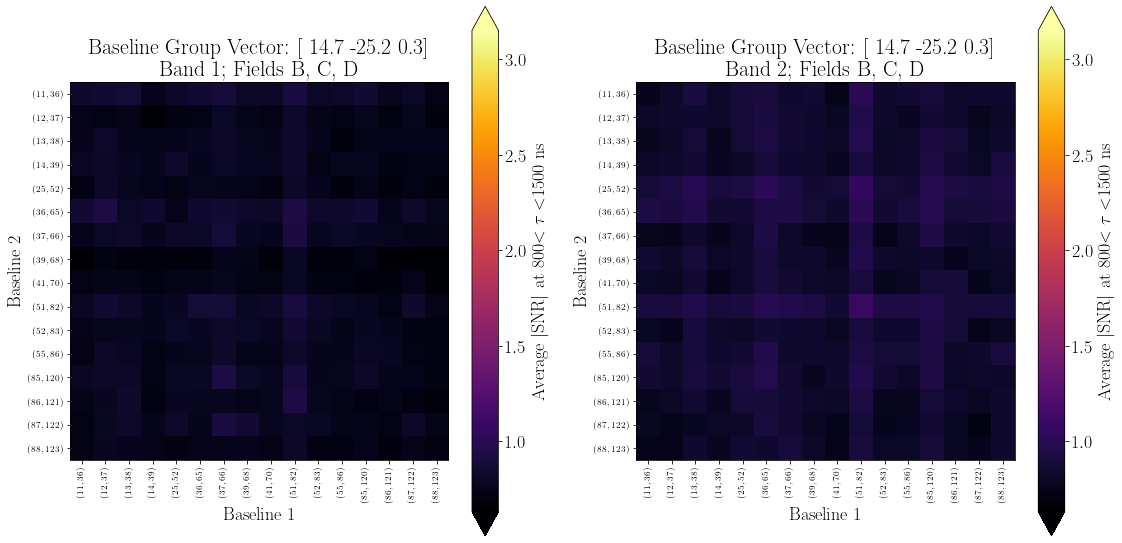

In [27]:
# loop over a number of representative baseline groups
for group_bl in [(11, 12), (1, 14), (1, 11), (1, 26), (11, 13), (11, 36)]:
    
    fig, axes = plt.subplots(1,2, figsize=(16,8))
    for ax, spw in zip(axes, [0, 1]):
        # get info about the group
        group_blp_key = (spw, (group_bl, group_bl), ('pI', 'pI'))
        ind = find_index_of_key(group_blp_key, uvps_xtk)
        blvec = np.mean(uvps_xtk[ind].get_blpair_blvecs(), axis=0)
        
        # construct matrix from dictionaries
        bls = sorted(set([bl for blp in uvps_xtk[ind].get_blpairs() for bl in blp]))
        bl_to_ind = {bl: n for n, bl in enumerate(bls)}
        xtalk_matrix = np.zeros((len(bls), len(bls)))
        for blp in uvps_xtk[ind].get_blpairs():
            key = (spw, blp, ('pI', 'pI'))
            bl1, bl2 = key[1]
            # only plot positive delays, this can be modified to 'abs' or 'neg' but then the colorbar label should be also modified
            xtalk_matrix[bl_to_ind[bl1], bl_to_ind[bl2]] = xtalk_SNRs['pos'][spw][key] 
        
        
        ax = axes.flatten()[spw]
        im = ax.imshow(xtalk_matrix, cmap='inferno', vmin=.63, vmax=.63*5)

        ax.set_xticks(np.arange(len(bls)))
        ax.set_xticklabels(bls, fontdict={'rotation': 'vertical', 'fontsize': 9})
        ax.set_yticks(np.arange(len(bls)))
        ax.set_yticklabels(bls, fontdict={'rotation': 'horizontal', 'fontsize': 9})
        
        # turn baseline labels that will be cut red
        for i, diag_entry in enumerate(np.diag(xtalk_matrix)):
            if diag_entry > auto_xtalk_snr_cut:
                ax.get_xticklabels()[i].set_color("red")
                ax.get_yticklabels()[i].set_color("red")                
        
        ax.set_title(f'Baseline Group Vector: {np.round(blvec,1)}\n Band {spw+1}; Fields {", ".join(["ABCDEFGHIJ"[f] for f in SNR_fields_to_use])}')
        plt.colorbar(im, ax=ax, extend='both',
                     label='Average $|$SNR$|$ at ' + f'{xtalk_dly_min}' + '$<\\tau <$' + f'{xtalk_dly_max} ns')
        ax.set_xlabel('Baseline 1')
        ax.set_ylabel('Baseline 2')        

    plt.tight_layout()
    
    # only bother to save the first baseline group
    if group_bl == (11, 12):
        plt.savefig(f'{figures_folder}/{prefix}xtalk_snr_matrix.pdf', dpi=200)

## Generate cuts based on residual cross-talk

In [28]:
uvps_xtk[0].spw_array

array([0, 1], dtype=uint16)

In [29]:
all_keys = sorted(set([key for uvp in uvps_xtk for key in uvp.get_all_keys()]))
# these are used for utils.red_avg
flag_neg_delays = {k: False for k in all_keys}
flag_pos_delays = {k: False for k in all_keys}

flagged_bls = {spw: {dly: set([]) for dly in ['pos', 'neg']} for spw in uvps_xtk[0].spw_array}

# figure out which baselines and baselines pairs are flagged at pos and/or neg delay
for key in all_keys:
    spw = key[0]
    bl1, bl2 = key[1][0], key[1][1]
    if xtalk_SNRs['pos'][spw][spw, (bl1, bl1), key[2]] > auto_xtalk_snr_cut:
        flag_pos_delays[key] = True
        flagged_bls[spw]['pos'].add(bl1)
    if xtalk_SNRs['pos'][spw][spw, (bl2, bl2), key[2]] > auto_xtalk_snr_cut:
        flag_pos_delays[key] = True
        flagged_bls[spw]['pos'].add(bl2)    
    if xtalk_SNRs['neg'][spw][spw, (bl1, bl1), key[2]] > auto_xtalk_snr_cut:
        flag_neg_delays[key] = True
        flagged_bls[spw]['neg'].add(bl1)
    if xtalk_SNRs['neg'][spw][spw, (bl2, bl2), key[2]] > auto_xtalk_snr_cut:
        flag_neg_delays[key] = True
        flagged_bls[spw]['neg'].add(bl2)                
        
flag_all_delays = {k: flag_pos_delays[k] and flag_neg_delays[k] for k in all_keys}    

# write out text files with flagged baselines:
for spw in uvps_xtk[0].spw_array:
    for dly in ['pos', 'neg']:
        with open(f'{results_folder}/flagged_bls_band_{spw+1}_{dly}_dlys.txt', 'w') as outfile:
            for bl in flagged_bls[spw][dly]:
                outfile.write(f'{bl}\n')

# for scatter plots
to_flag_xtalk = {fname: {spw: (auto_blp1_xtalk_snrs[fname][spw] >= auto_xtalk_snr_cut) | (auto_blp2_xtalk_snrs[fname][spw] >= auto_xtalk_snr_cut) 
                         for spw in xtalk_SNRs[fname]} for fname in xtalk_SNRs}        

### Crosstalk auto-baseline SNR distribution

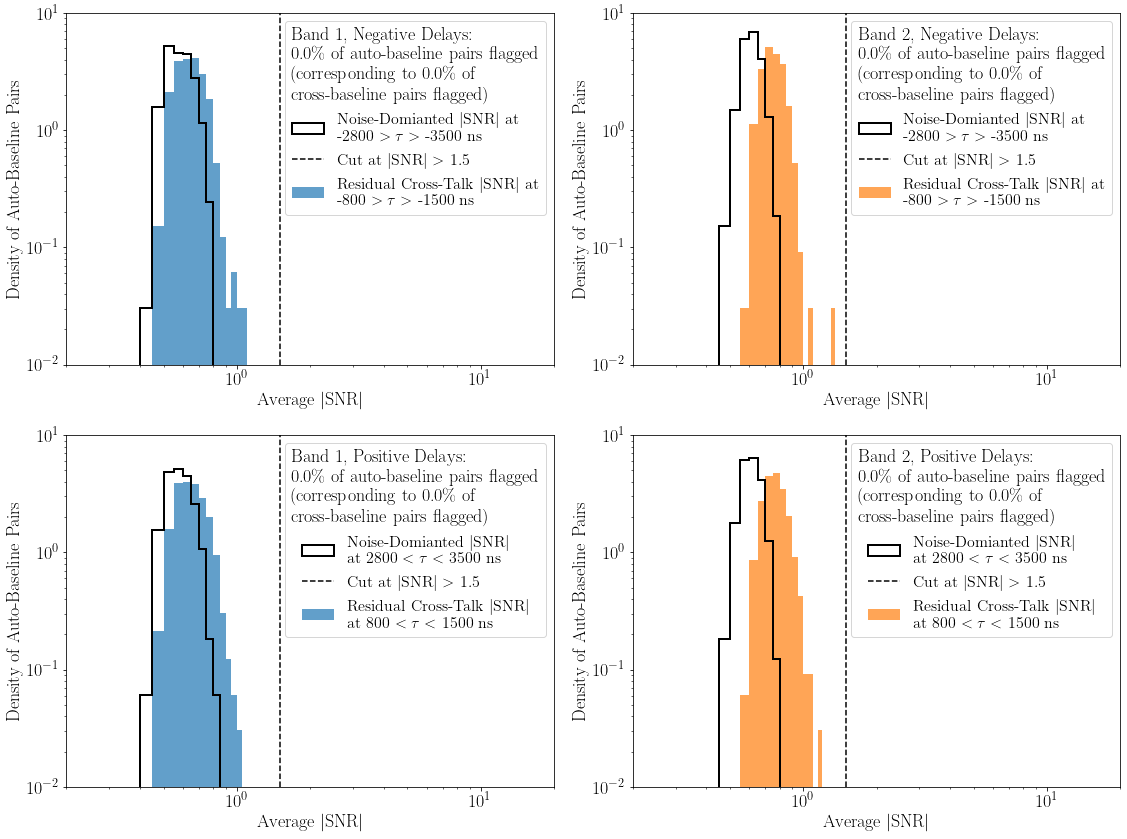

In [30]:
fig, axes = plt.subplots(2,2, figsize=(16,12))

for axis, fname in zip(axes, ['neg', 'pos']):

    for spw, ax in enumerate(axis):
        flag_delays = [flag_neg_delays, flag_pos_delays][fname == 'pos']
        auto_flags_here = [flag_delays[k] for k in flag_delays if (k[0] == spw) and (k[1][0] == k[1][1])]
        cross_flags_here = [flag_delays[k] for k in flag_delays if (k[0] == spw) and (k[1][0] != k[1][1])]
            
        label = f'Band {spw+1} Flags:\n'

        
        if fname == 'pos':
            label1 = f'Residual Cross-Talk $|$SNR$|$\nat {xtalk_dly_min} ' + '$<\\tau <$' + f' {xtalk_dly_max} ns'
            label2 = f'Noise-Domianted $|$SNR$|$\nat {xtalk_dly_min + high_dly_diff} ' + '$<\\tau <$' + f' {xtalk_dly_max + high_dly_diff} ns'
        else:
            label1 = (f'Residual Cross-Talk $|$SNR$|$ at\n-{xtalk_dly_min} ' + '$>\\tau >$' + f' -{xtalk_dly_max} ns') 
            label2 = (f'Noise-Domianted $|$SNR$|$ at\n-{xtalk_dly_min + high_dly_diff} ' + '$>\\tau >$' + f' -{xtalk_dly_max + high_dly_diff} ns') 
        
        
        ax.hist(auto_xtalk_snrs[fname][spw], bins=np.arange(.4,10,.05), density=True, alpha=.7, color=['C0', 'C1'][spw], label=label1)        
        ax.hist(auto_high_dly_snrs[fname][spw], bins=np.arange(.4,10,.05), density=True, histtype='step', lw=2, color='k', label=label2)

        ax.set_ylabel('Density of Auto-Baseline Pairs')
        ax.set_xlabel(f'Average $|$SNR$|$')

        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlim([.2, 20])

        ax.set_ylim([1e-2, 10])
        v2 = ax.axvline(auto_xtalk_snr_cut, linestyle='--', color='k', label='Cut at $|$SNR$|  >$ ' + f'{auto_xtalk_snr_cut:.1f}')

        title = f'Band {spw + 1}, {["Negative", "Positive"][fname == "pos"]} Delays:\n'
        title += f'{100 * np.sum(auto_flags_here) / len(auto_flags_here):.1f}\% of auto-baseline pairs flagged\n'
        title += f'(corresponding to {100 * np.sum(cross_flags_here) / len(cross_flags_here):.1f}\% of \ncross-baseline pairs flagged)'
        
        ax.legend()
        handles, labels = ax.get_legend_handles_labels()
        order = [1, 2, 0]
        ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], title=title, fontsize=16)

plt.tight_layout()
plt.savefig(f'{figures_folder}/{prefix}auto_xtalk_SNR_hist.pdf', dpi=200)

### Show relationship between auto-baseline pair residual cross-talk and cross-baseline pair residual cross-talk

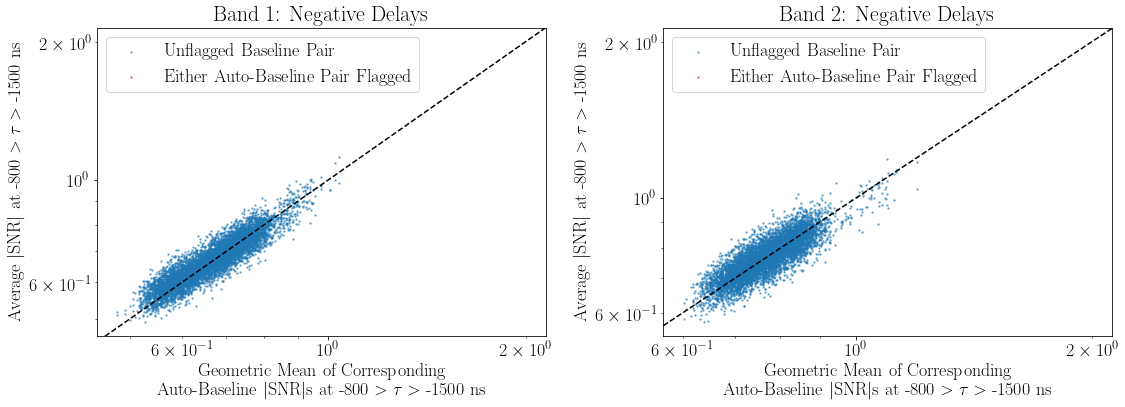

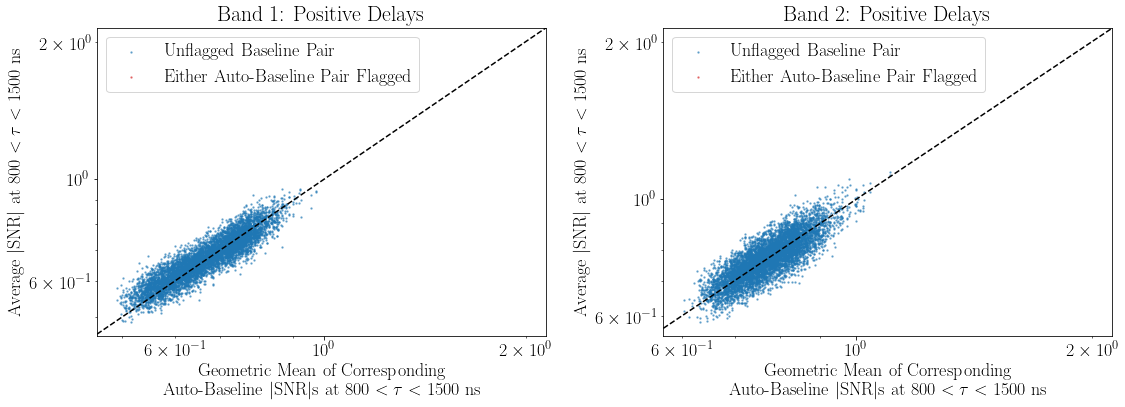

In [31]:
for fname in ['neg', 'pos']:
    fig, axes = plt.subplots(1,2, figsize=(16,6))
    for i, ax in enumerate(axes):
        to_flag = to_flag_xtalk[fname][i]
        ax.scatter(np.sqrt(auto_blp1_xtalk_snrs[fname][i][~to_flag] * auto_blp2_xtalk_snrs[fname][i][~to_flag]), cross_xtalk_snrs[fname][i][~to_flag], 
                   s=2, color='C0', alpha=.5, label='Unflagged Baseline Pair')
        ax.scatter(np.sqrt(auto_blp1_xtalk_snrs[fname][i][to_flag] * auto_blp2_xtalk_snrs[fname][i][to_flag]), cross_xtalk_snrs[fname][i][to_flag], 
                   s=2, color='C3', alpha=.5, label='Either Auto-Baseline Pair Flagged')
        ax.set_yscale('log')
        ax.set_xscale('log')
        
        if fname == 'pos':
            tau_str = f'{xtalk_dly_min} ' + '$<\\tau <$' + f' {xtalk_dly_max} ns'
        else:
            tau_str = f'-{xtalk_dly_min} ' + '$>\\tau >$' + f' -{xtalk_dly_max} ns'
        ax.set_ylabel('Average $|$SNR$|$ at ' + tau_str)
        ax.set_xlabel('Geometric Mean of Corresponding\nAuto-Baseline $|$SNR$|$s at '+ tau_str)
        
        ax.set_title(f'Band {i+1}: ' + ['Negative', 'Positive'][fname == 'pos'] + ' Delays')
        ax.axline((1,1), (2,2), linestyle='--', color='k')
        ax.legend()
    plt.tight_layout()

### Show what fraction of each baseline group was flagged as a result of cross-talk SNR flagging

invalid value encountered in true_divide


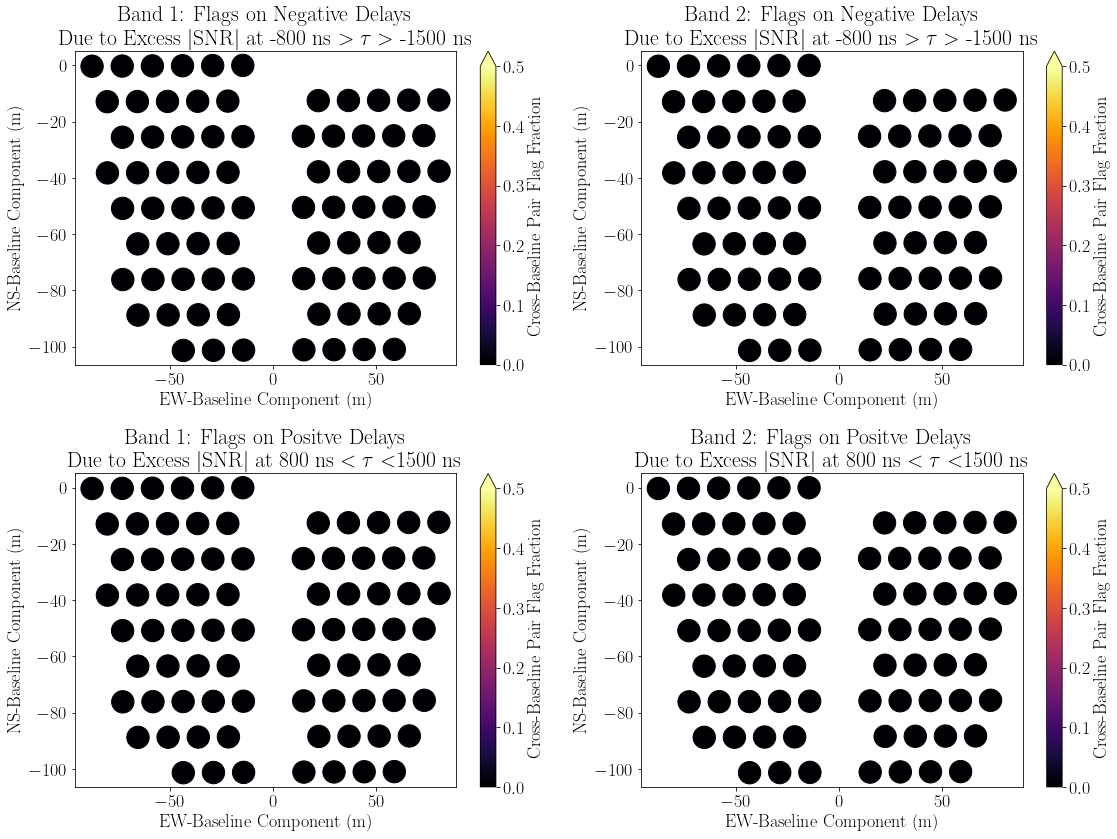

In [32]:
fig, axes = plt.subplots(2,2, figsize=(16,12))

for spw in [0, 1]:
    for i, (fname, label, flag_delays) in enumerate(zip(['neg', 'pos'], ['Negative', 'Positve'], [flag_neg_delays, flag_pos_delays])):
        ax = axes[i, spw]
        bl_vecs = [np.mean(uvp.get_blpair_blvecs(), axis=0) for uvp in uvps_xtk]
        n_flags = [np.sum([flag_delays[k] for k in uvp.get_all_keys() if (k[0]==spw) and (k[1][0] != k[1][1]) and np.isfinite(xtalk_SNRs[fname][spw][k])]) for uvp in uvps_xtk]
        n_bls = [np.sum([np.isfinite(xtalk_SNRs[fname][spw][k]) for k in uvp.get_all_keys() if (k[0]==spw) and (k[1][0] != k[1][1])]) for uvp in uvps_xtk]
        sca = ax.scatter([blvec[0] for blvec in bl_vecs], 
                         [blvec[1] for blvec in bl_vecs],
                         c=np.array(n_flags) / np.array(n_bls),
                         cmap='inferno', s=500, edgecolors='k', vmax=.5, vmin=0)
        plt.colorbar(sca, ax=ax, label='Cross-Baseline Pair Flag Fraction', extend='max')
        ax.set_xlabel('EW-Baseline Component (m)')
        ax.set_ylabel('NS-Baseline Component (m)')
        if fname == 'pos':
            ax.set_title(f'Band {spw+1}: Flags on {label} Delays\nDue to Excess $|$SNR$|$ at {xtalk_dly_min} ns ' + '$<\\tau <$' + f'{xtalk_dly_max} ns')        
        else:
            ax.set_title(f'Band {spw+1}: Flags on {label} Delays\nDue to Excess $|$SNR$|$ at -{xtalk_dly_min} ns ' + '$>\\tau >$' + f' -{xtalk_dly_max} ns')        
plt.tight_layout()
plt.savefig(f'{figures_folder}/{prefix}delay_flagging_fraction.png', dpi=200)

# Incoherent redundant (cylindrically) average

In [33]:
# weight redundant average by P_N, but propagate P_SN errorbar
history = "Bias Corrected:\ndata + error bias correction per spw {}\nother data-only bias correction per spw{}\n" \
          "Incoherent redundantly averaged, excluding auto-baseline-pairs, weighted by P_N" \
          "".format(abscal_bias, other_bias)
uvp_xtk_ravg = utils.red_avg(uvps_xtk, exclude_autos=True, error_weights='P_N', error_field=['P_SN'], add_to_history=history,
                             flag_all_delays=flag_all_delays, flag_pos_delays=flag_pos_delays, flag_neg_delays=flag_neg_delays)
uvp_tk_ravg = utils.red_avg(uvps_tk, exclude_autos=True, error_weights='P_N', error_field=['P_SN'], add_to_history=history,
                            flag_all_delays=flag_all_delays, flag_pos_delays=flag_pos_delays, flag_neg_delays=flag_neg_delays)

## Show $P(\tau = 0)$ and $P_N$ to help define fields

invalid value encountered in power
invalid value encountered in power
Casting complex values to real discards the imaginary part


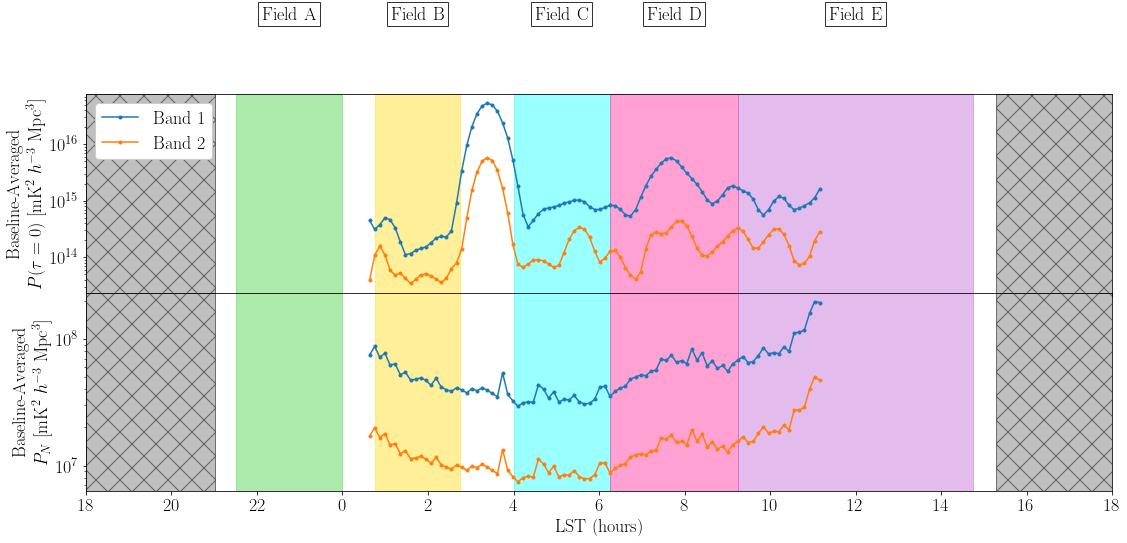

In [34]:
# inverse variance weight and average power spectra and noise power spectra
bl_avg_pspec, bl_avg_noise = {}, {}
for spw in [0,1]:
    bl_avg_pspec[spw] = np.ma.average([uvp_xtk_ravg.get_data(key) for key in uvp_xtk_ravg.get_all_keys() if key[0] == spw], axis=0,
                                       weights=[np.where(np.isfinite(uvp_xtk_ravg.get_stats('P_N', key)), 
                                                uvp_xtk_ravg.get_stats('P_N', key)**-2, 0) 
                                       for key in uvp_xtk_ravg.get_all_keys() if key[0] == spw])
    bl_avg_noise[spw] = np.ma.average([np.where(np.isfinite(uvp_xtk_ravg.get_stats('P_N', key)), 
                                                uvp_xtk_ravg.get_stats('P_N', key), 0) 
                                       for key in uvp_xtk_ravg.get_all_keys() if key[0] == spw], 
                                       axis=0,
                                       weights=[np.where(np.isfinite(uvp_xtk_ravg.get_stats('P_N', key)), 
                                                uvp_xtk_ravg.get_stats('P_N', key)**-2, 0) 
                                       for key in uvp_xtk_ravg.get_all_keys() if key[0] == spw])    


lst_indexes = np.unique(uvp_xtk_ravg.lst_1_array, return_index=True)[1]
lsts_wrapped = np.unwrap([uvp_xtk_ravg.lst_avg_array[i] for i in sorted(lst_indexes)]) * 12 / np.pi
while np.max(lsts_wrapped) > 24:
    lsts_wrapped -= 24
dlys = np.unique(uvp_xtk_ravg.dly_array)    
    
fig, axes = plt.subplots(2, 1, figsize=(16,8), sharex=True, gridspec_kw={'hspace': 0})

for spw in [0, 1]:
    axes[0].semilogy(lsts_wrapped, bl_avg_pspec[spw][:, bl_avg_pspec[spw].shape[1]//2], '.-', label=f'Band {spw+1}')
axes[0].set_ylabel('Baseline-Averaged\n'+r'$P(\tau = 0)\ [{\rm mK}^2\ h^{-3}\ {\rm Mpc}^3]$')

for field, (lc, c) in enumerate(zip(lstcuts, lst_colors)):
    axes[0].axvspan(lc[0], lc[1], color=c, alpha=.4)
    axes[0].text(np.mean(lc), 2e18, f'Field {"ABCDEFGHIJ"[field]}', ha='center', va='center', bbox=dict(facecolor='w', alpha=0.8))

for spw in [0, 1]:
    axes[1].semilogy(lsts_wrapped, bl_avg_noise[spw][:, bl_avg_noise[spw].shape[1]//2], '.-', label=f'Band {spw+1}')
axes[1].set_ylabel('Baseline-Averaged\n'+r'$P_N\ [{\rm mK}^2\ h^{-3}\ {\rm Mpc}^3]$')

for lc, c in zip(lstcuts, lst_colors):
    axes[1].axvspan(lc[0], lc[1], color=c, alpha=.4)    
axes[1].set_xlabel('LST (hours)')  

for ax in axes:
    ax.set_xticks(np.arange(-6, 20, 2))
    ax.set_xlim([-6,18])
    poly = ax.axvspan(-6, 24 * 5.5/2/np.pi - 24, color='grey', alpha=.5)
    poly.set_hatch('X')
    poly.set_edgecolor('k')
    poly = ax.axvspan(24 * 4/2/np.pi, 19, color='grey',alpha=.5)    
    poly.set_hatch('X')    
    poly.set_edgecolor('k')
axes[1].set_xticklabels(np.arange(-6, 20, 2) % 24)

axes[0].legend(loc='upper left', framealpha=1)


plt.tight_layout()
plt.savefig(f'{figures_folder}/{prefix}fields_vs_noise_and_power.pdf', dpi=200)

## Show stats after the redundant average

In [35]:
blvec_dict = {}
SNRs = {}
field_int_times = {}

spw = 1
uvp = uvp_xtk_ravg

for n, (blp, blvec) in enumerate(zip(uvp_tk_ravg.get_blpairs(), uvp_tk_ravg.get_blpair_blvecs())):
    key=(spw, blp, ('pI', 'pI'))
    blvec_dict[key] = blvec
    horiz_dly = np.linalg.norm(blvec / constants.c.value)
    
    # recompute average SNR per baseline group
    SNRs[key] = {}
    field_int_times[key] = {}
    SNR = np.real(uvp.get_data(key)) / np.abs(uvp.get_stats('P_N', key))
    SNR = np.where(np.isfinite(SNR), SNR, np.nan)

    lst_indexes = np.unique(uvp_tk_ravg.lst_1_array, return_index=True)[1]
    lsts_wrapped = np.unwrap([uvp_tk_ravg.lst_1_array[i] for i in sorted(lst_indexes)]) * 12 / np.pi
    while np.max(lsts_wrapped) > 24:
        lsts_wrapped -= 24

    dlys = uvp_tk_ravg.get_dlys(key[0])
    
    total_inttime = uvp.get_integrations(key) * uvp.get_nsamples(key)
    
    # save average SNR and total integration time per field
    for lstcut in lstcuts:
        snr_here = SNR[np.logical_and(lsts_wrapped < lstcut[1], lsts_wrapped>  lstcut[0])]
        SNRs[key][lstcut] = np.nanmean(np.abs(snr_here[:, (np.abs(dlys) > xtalk_dly_min/1e9) & (np.abs(dlys) < xtalk_dly_max/1e9)]))        
        field_int_times[key][lstcut] = np.sum(total_inttime[(lsts_wrapped < lstcut[1]) & (lsts_wrapped>  lstcut[0]) & (np.all(np.isfinite(SNR), axis=1))])

### Total baseline-pair seconds per baseline group

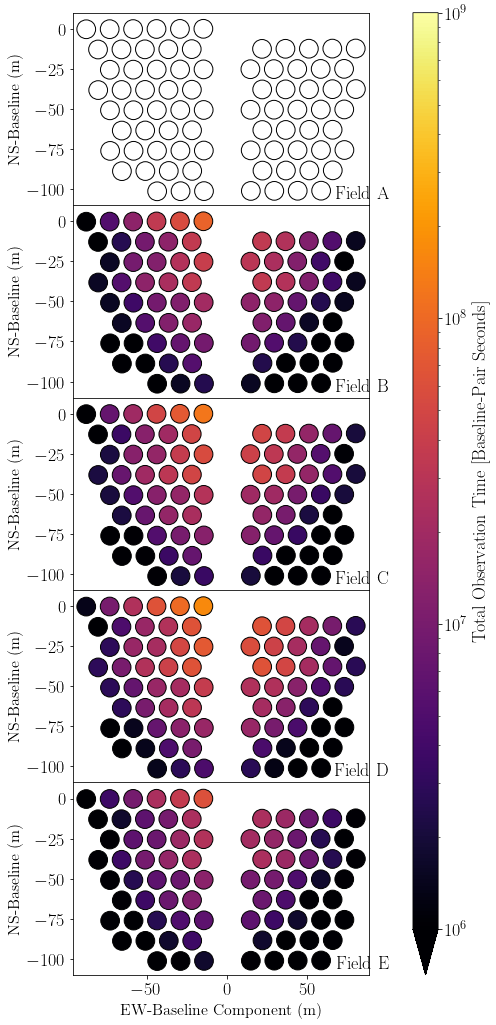

In [36]:
fig, axes = plt.subplots(len(lstcuts),1, figsize=(7,14.5), sharex=True, gridspec_kw={'hspace': 0})

for i, lstcut in enumerate(lstcuts):
    ax = axes.flatten()[i]
    blvecs = np.array([blvec for blvec in uvp_tk_ravg.get_blpair_blvecs()])
    int_times = np.array([])
    for n, (blp, blvec) in enumerate(zip(uvp_tk_ravg.get_blpairs(), uvp_tk_ravg.get_blpair_blvecs())):
        key=(spw, blp, ('pI', 'pI'))
        int_times = np.append(int_times, field_int_times[key][lstcut])
    scatter = ax.scatter(blvecs[:,0], blvecs[:,1], c=int_times, s=350, cmap='inferno', edgecolors='k', norm=matplotlib.colors.LogNorm(vmin=1e6, vmax=1e9))
    ax.set_aspect('equal')
    ax.set_ylim([-110, 10])
    if i == (len(lstcuts) - 1):
        ax.set_xlabel('EW-Baseline Component (m)', fontsize=16)
        
    ax.set_ylabel('NS-Baseline (m)', fontsize=16)
    ax.text(101, -103, f'Field {"ABCDEFGHIJ"[i]}', va='center', ha='right')#, bbox=dict(facecolor='w', alpha=0.8))
plt.tight_layout()

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.8, axes[-1].get_position().extents[1], 0.05, 
                        axes[0].get_position().extents[-1] - axes[-1].get_position().extents[1]])
fig.colorbar(scatter, cax=cbar_ax, label='Total Observation Time [Baseline-Pair Seconds]', extend='min')

### Residual cross-talk after flagging and averaging

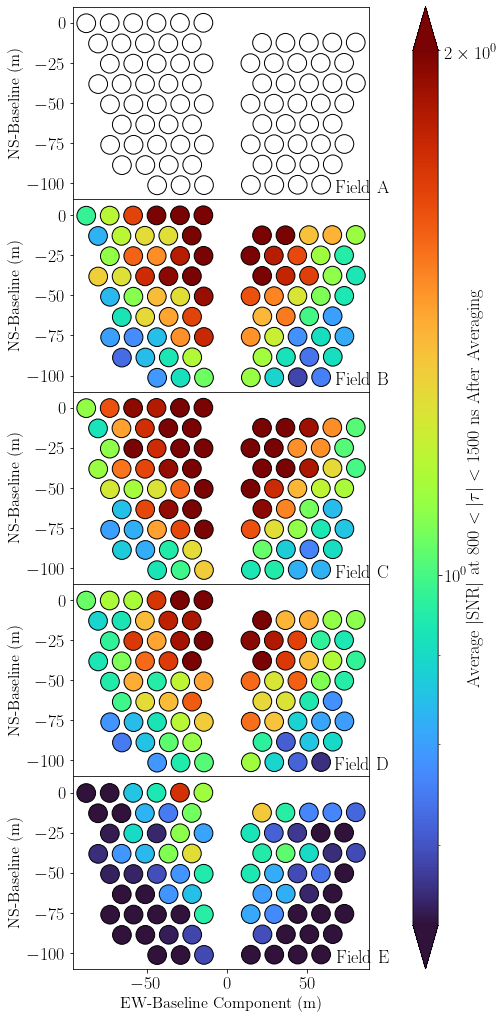

In [37]:
fig, axes = plt.subplots(len(lstcuts), 1, figsize=(7,14.5), sharex=True, gridspec_kw={'hspace': 0})

for i, lstcut in enumerate(lstcuts):
    ax = axes.flatten()[i]
    blvecs = np.array([blvec for blvec in uvp_tk_ravg.get_blpair_blvecs()])
    avg_snrs = np.array([])
    for n, (blp, blvec) in enumerate(zip(uvp_tk_ravg.get_blpairs(), uvp_tk_ravg.get_blpair_blvecs())):
        key=(spw, blp, ('pI', 'pI'))
        if SNRs[key][lstcut] == 0:
            avg_snrs = np.append(avg_snrs, 0)
        else:
            avg_snrs = np.append(avg_snrs, SNRs[key][lstcut])
    scatter = ax.scatter(blvecs[:,0], blvecs[:,1], c=avg_snrs, s=350, cmap='turbo', edgecolors='k', norm=matplotlib.colors.LogNorm())
    scatter.set_clim([.63, 2])
    ax.set_aspect('equal')
    ax.set_ylim([-110, 10])
    if i == (len(lstcuts) - 1):
        ax.set_xlabel('EW-Baseline Component (m)', fontsize=16)
        
    ax.set_ylabel('NS-Baseline (m)', fontsize=16)
    ax.text(101, -103, f'Field {"ABCDEFGHIJ"[i]}', va='center', ha='right')#, bbox=dict(facecolor='w', alpha=0.8))

plt.tight_layout()
    
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.8, axes[-1].get_position().extents[1], 0.05, 
                        axes[0].get_position().extents[-1] - axes[-1].get_position().extents[1]])
cbar = fig.colorbar(scatter, cax=cbar_ax,  extend='both')
cbar.set_label(label='Average $|$SNR$|$ at ' + f'{xtalk_dly_min}' + ' $<|\\tau |<$ ' + f'{xtalk_dly_max} ns After Averaging', labelpad=-30)
    
plt.savefig(f'{figures_folder}/{prefix}redundant_avg_xtalk_SNR_band_{spw+1}.pdf', dpi=200)

# 3. Incoherent time average in LST fields

In [38]:
# make LST cuts
fields_used = []
uvp_xtk_tavg, uvp_tk_tavg = [], []
for field, lc in enumerate(lstcuts):
    # weight time-average by P_N
    history = "LST cut {} hours, average weighted by P_N".format(lc)
    lst_indexes = np.unique(uvp_xtk_ravg.lst_1_array, return_index=True)[1]
    lsts = np.array([uvp_xtk_ravg.lst_avg_array[i] for i in sorted(lst_indexes)])
    lsts_hrs = np.unwrap(lsts) * 12 / np.pi 
    while np.max(lsts_hrs) > 24:
        lsts_hrs -= 24
    
    lcut = (lsts_hrs >= lc[0]) & (lsts_hrs <= lc[1])
    if not np.any(lcut):
        continue
    
    # average with cross-talk subtraction 
    u = uvp_xtk_ravg.select(lsts=lsts[lcut], inplace=False)
    if not np.any(np.isfinite(u.stats_array['P_N'][0])):
        if not np.any(np.isfinite(u.stats_array['P_N'][1])):
            continue
    u.average_spectra(time_avg=True, error_weights='P_N', error_field=['P_SN'], add_to_history=history)
    uvp_xtk_tavg.append(u)

    # average without cross-talk subtraction
    u = uvp_tk_ravg.select(lsts=lsts[lcut], inplace=False)
    u.average_spectra(time_avg=True, error_weights='P_N', error_field=['P_SN'], add_to_history=history)
    uvp_tk_tavg.append(u)
    
    fields_used.append(field)    

## Cylindrical Power Spectra and SNR

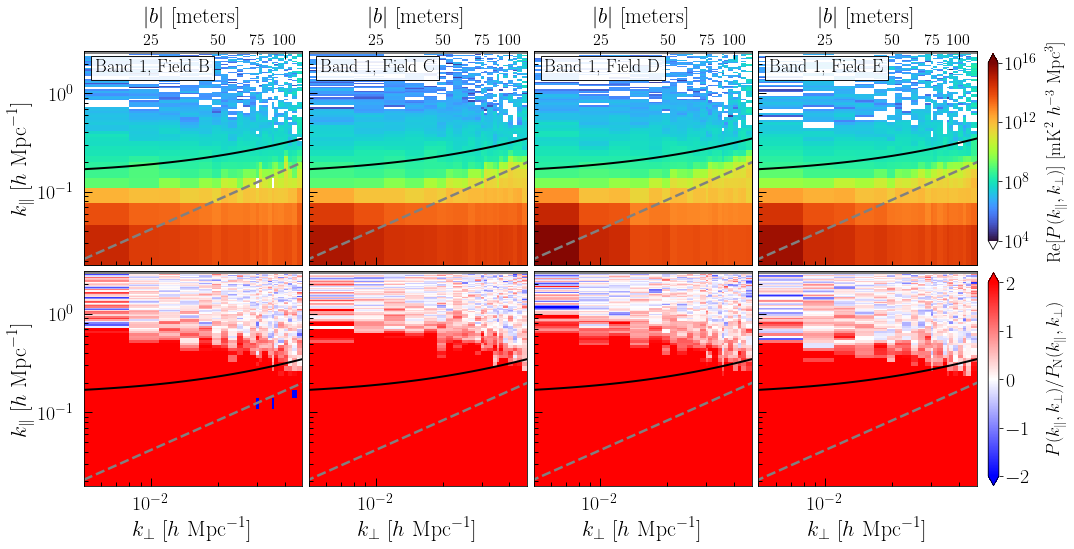

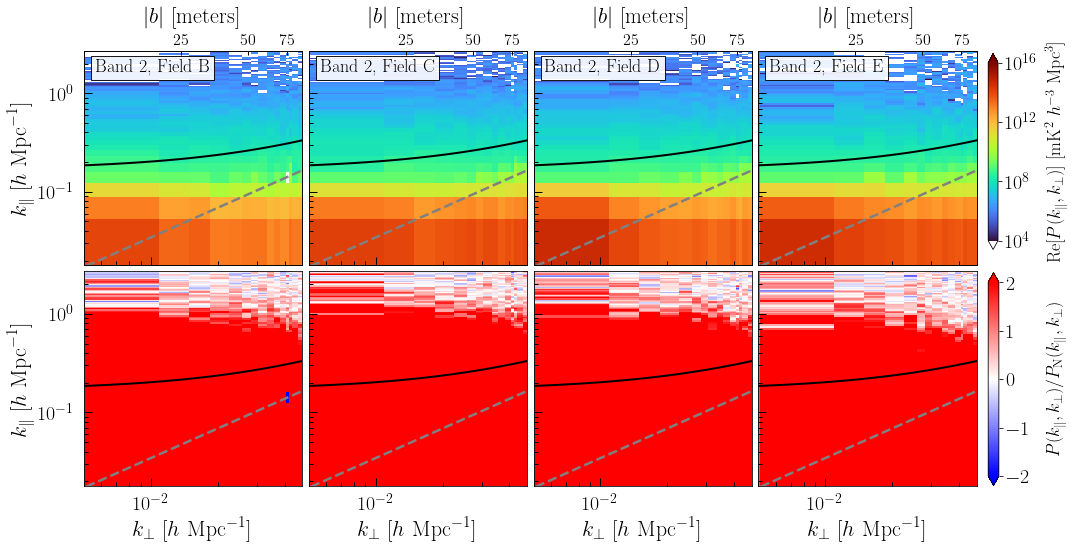

In [39]:
# basic settings
component = 'real'
cmap1 = plt.get_cmap("turbo").copy()
cmap1.set_bad('w')
if 'abs' in component:
    cmap1.set_under(plt.cm.turbo([0])[0])
else:
    cmap1.set_under('w')
cmap2 = plt.get_cmap("bwr")

xlim = 0.005, 0.048
ylim = 0.018, 2.7

for spw in [0, 1]:

    fig, axes = plt.subplots(2, len(uvp_xtk_tavg), figsize=(16, 8))
    fig.subplots_adjust(wspace=0.03, hspace=0.03)


    for i in range(2):
        for j in range(len(uvp_xtk_tavg)):
            ax = axes[i, j]
            ax.axvspan(0, 1, 0, 1, color='grey', zorder=0)
            
            # select only baseline pairs with finite noise
            u = copy.deepcopy(uvp_xtk_tavg[j])
            good_blps = set([])
            for key in u.get_all_keys():
                if key[0] == spw:
                    if np.all(np.isfinite(u.get_stats('P_N', key))):
                        good_blps.add(key[1])
            if len(good_blps) == 0:
                continue
            u.select(blpairs=sorted(good_blps))

            if i == 0:
                ax2, ax3 = utils.wedge_plot(u, ax, spw, dly_label=False, cmap=cmap1, component=component, error_weights='P_N',
                                            xlim=xlim, ylim=ylim, twinx=False, twiny=True, fontsize=22, log10=False,
                                            norm=matplotlib.colors.LogNorm(vmin=1e4, vmax=1e16))
                ax2.set_xticks([100], minor=False); ax2.set_xticklabels([100], minor=False)
                ax2.set_xticks([25, 50, 75], minor=True); ax2.set_xticklabels([25, 50, 75], minor=True)
            else:
                u.data_array[spw] /= u.stats_array['P_N'][spw].real
                ax2, ax3 = utils.wedge_plot(u, ax, spw, dly_label=False, cmap=cmap2, component=component, log10=False,
                                 xlim=xlim, ylim=ylim, fontsize=22, twinx=False, twiny=False, vmin=-2, vmax=2)
            ax.tick_params(labelsize=20)
            if j > 0:
                ax.set_yticklabels([])
                ax.set_ylabel('')
            if i == 0:
                ax.set_xticklabels([])
                ax.set_xlabel('')
            if i == 0:
                ax.text(0.05, 0.9, "Band {}, Field {}".format(spw+1, "ABCDEFGHIJ"[fields_used[j]]), fontsize=18, transform=ax.transAxes, 
                        color='k', bbox=dict(facecolor='w', alpha=0.9))
            # plot buffer
            x = np.linspace(5, 120)  # meters
            y = 1e9 / scipy.constants.c * x + wedge_buff_ns  # ns
            z = u.cosmo.f2z(np.mean(u.get_spw_ranges(spw)[0][:2]))
            kperp, kpara = x * u.cosmo.bl_to_kperp(z, little_h=True), y * u.cosmo.tau_to_kpara(z, little_h=True) / 1e9
            ax.plot(kperp, kpara, c='k', lw=2)

        if i == 0:
            cbax = fig.add_axes([0.825, 0.535, 0.1, 0.34])
        else:
            cbax = fig.add_axes([0.825, 0.125, 0.1, 0.37])
        cbax.axis('off')
        cax = ax.collections[0]
        extend = 'both' if i == 0 else 'both'
        cbar = fig.colorbar(cax, ax=cbax, extend=extend)
        cbar.ax.tick_params(labelsize=20, direction='out', size=4)
        if i== 0:
            cbar.set_label(r"$\mbox{Re}[P(k_\parallel, k_\perp)]\ [{\rm mK}^2\ h^{-3}\ {\rm Mpc}^3]$", fontsize=18, labelpad=8)
            cbar.ax.set_xlabel("$< 0$", labelpad=2, fontsize=15)
        else:
            cbar.set_label(r"$P(k_\parallel, k_\perp) / P_{\rm N}(k_\parallel,k_\perp)$", fontsize=18, labelpad=15)

    plt.savefig(f'{figures_folder}/{prefix}Cylindrical_Pk_Band_{spw+1}.png', dpi=200)

## Cylindrical Power Spectrum Noise

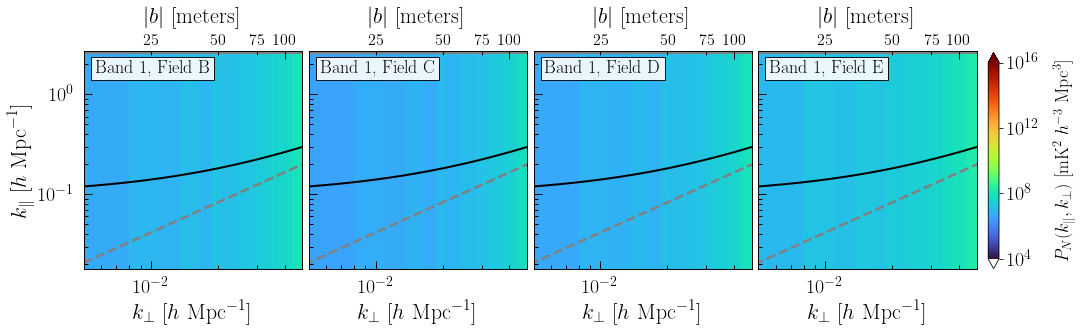

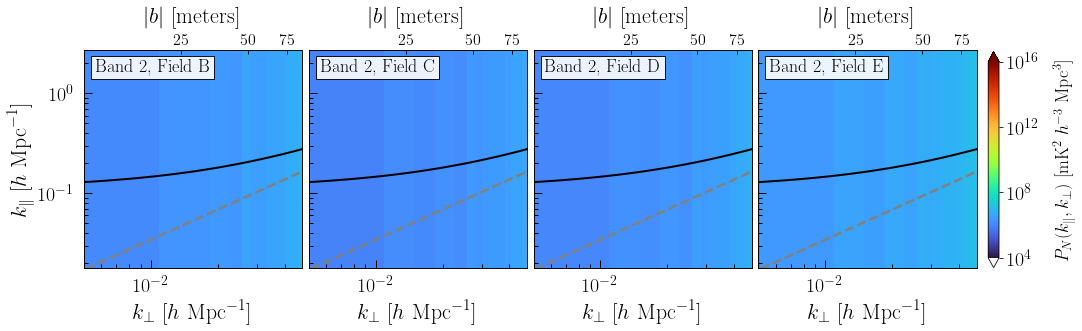

In [40]:
for spw in [0, 1]:
    fig, axes = plt.subplots(1, len(uvp_xtk_tavg), figsize=(16, 4))
    fig.subplots_adjust(wspace=0.03, hspace=0.03)
    for j in range(len(uvp_xtk_tavg)):
        ax = axes[j]
        ax.axvspan(0, 1, 0, 1, color='grey', zorder=0)

        # select only baseline pairs with finite noise
        u = copy.deepcopy(uvp_xtk_tavg[j])
        good_blps = set([])
        for key in u.get_all_keys():
            if key[0] == spw:
                if np.all(np.isfinite(u.get_stats('P_N', key))):
                    good_blps.add(key[1])
        if len(good_blps) == 0:
            continue
        u.select(blpairs=sorted(good_blps))
        
        u.data_array[spw] = copy.deepcopy(u.stats_array['P_N'][spw])

        ax2, ax3 = utils.wedge_plot(u, ax, spw, dly_label=False, cmap=cmap1, component=component, error_weights='P_N',
                                    xlim=xlim, ylim=ylim, twinx=False, twiny=True, fontsize=22, log10=False,
                                    norm=matplotlib.colors.LogNorm(vmin=1e4, vmax=1e16))
        ax2.set_xticks([100], minor=False); ax2.set_xticklabels([100], minor=False)
        ax2.set_xticks([25, 50, 75], minor=True); ax2.set_xticklabels([25, 50, 75], minor=True)
        ax.tick_params(labelsize=20)
        if j > 0:
            ax.set_yticklabels([])
            ax.set_ylabel('')
        ax.text(0.05, 0.9, "Band {}, Field {}".format(spw+1, "ABCDEFGHIJ"[fields_used[j]]), fontsize=18, transform=ax.transAxes,
                bbox=dict(facecolor='w', alpha=0.9))

        # plot buffer
        x = np.linspace(5, 120)  # meters
        y = 1e9 / scipy.constants.c * x + 200  # ns
        z = u.cosmo.f2z(np.mean(u.get_spw_ranges(spw)[0][:2]))
        kperp, kpara = x * u.cosmo.bl_to_kperp(z, little_h=True), y * u.cosmo.tau_to_kpara(z, little_h=True) / 1e9
        ax.plot(kperp, kpara, c='k', lw=2)

    cbax = fig.add_axes([0.825, 0.125, 0.1, 0.75])
    cbax.axis('off')
    cax = ax.collections[0]
    cbar = fig.colorbar(cax, ax=cbax, extend='both')
    cbar.ax.tick_params(labelsize=20, direction='out', size=4)
    cbar.set_label(r"$P_N(k_\parallel, k_\perp)\ [{\rm mK}^2\ h^{-3}\ {\rm Mpc}^3]$", fontsize=18, labelpad=15)
    
    plt.savefig(f'{figures_folder}/{prefix}Cylindrical_P_N_Band_{spw+1}.png', dpi=200)

## Explore the distribution of noise-like bins

Tries to see if the distribution of apparently noise-dominated measurements is consistent with expectations

In [41]:
def bootstrap_mad(x, N=None, replace=False):
    '''Estimate the median absolute deviation with boostrapping'''
    if N is None:
        N = len(x)
    s = np.random.choice(np.arange(len(x)), size=N, replace=replace)
    return np.std(x[s])
    return np.median(np.abs(x[s] - np.median(x[s]))) * 1.4826

def bootstrap_std(x, N=None, replace=False):
    '''Estimate the standard deviation with boostrapping'''
    if N is None:
        N = len(x)
    s = np.random.choice(np.arange(len(x)), size=N, replace=replace)
    return np.std(x[s])

invalid value encountered in multiply


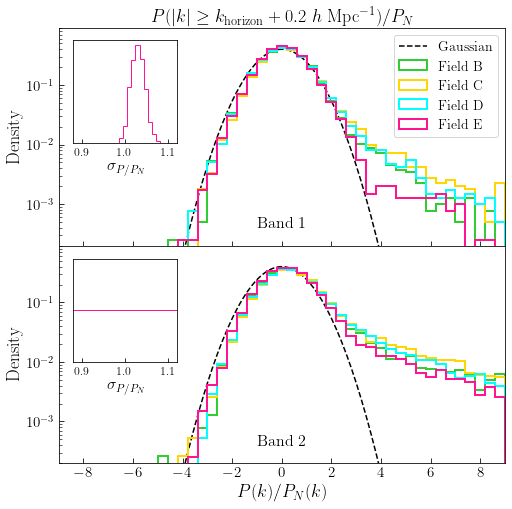

In [42]:
fig, axes = plt.subplots(2, 1, figsize=(8, 8))
fig.subplots_adjust(wspace=0, hspace=0)

xlim = -9, 9
ylim = 2e-4, 9e-1
colors = lst_colors

for spw, ax in enumerate(axes):
    ax.tick_params(labelsize=15, size=5, direction='in')
    ax.tick_params(size=3, direction='in', which='minor')
    # construct grid of kparas for each kperp with buffer of 0.2
    u = uvp_xtk_tavg[0]
    kp, bl_seps = u.get_kparas(spw), u.get_blpair_seps()
    z = u.cosmo.f2z(np.mean(u.get_spw_ranges(spw)[0][:2]))
    ks = []
    for ii, bl_sep in enumerate(bl_seps):
        ks.append(np.abs(kp) >= (1e9 / scipy.constants.c * bl_sep * u.cosmo.tau_to_kpara(z) / 1e9 + 0.2))
    ks = np.array(ks).ravel()
    ax2 = fig.add_axes([0.15, 0.68-spw*0.38, 0.18, 0.18])
    ax2.tick_params(labelsize=12, size=4, direction='in')
    ax2.set_yticks([])
    ax2.set_xlim(0.88, 1.12)
    ax2.set_xlabel(r"$\sigma_{P/P_{N}}$", fontsize=16)
    
    ax.plot(np.arange(xlim[0], xlim[1], .1), (2*np.pi)**-.5 * np.exp(-np.arange(xlim[0], xlim[1], .1)**2 / 2), 'k--', label='Gaussian')
    
    for i in range(len(uvp_xtk_tavg)):
        u = copy.deepcopy(uvp_xtk_tavg[i])
        for blp, blvec in zip(u.get_blpairs(), u.get_blpair_blvecs()):
            cut = False
            if np.linalg.norm(blvec) < sph_minimum_bl_length:
                cut = True
            if np.linalg.norm(blvec) > sph_maximum_bl_length:
                cut = True
            if np.abs(blvec[0]) < sph_minimum_ew_distance:
                cut = True
            if cut:
                for pp in u.get_polpairs():
                    key = (spw, blp, pp)
                    u.set_stats('P_N', key, np.ones_like(u.get_stats('P_N', key)) * np.inf)

        d = (u.data_array[spw].real / u.stats_array['P_N'][spw].real).ravel()[ks]
        d = d[~np.isclose(d, 0)]
        ax.hist(d, bins=45, range=xlim, histtype='step', lw=2, density=True, label='Field {}'.format("ABCDEFGHIJ"[fields_used[i]]), color=colors[i])
        
        bs = [bootstrap_std(d, replace=True) for _ in range(500)]
        ax2.hist(bs, bins=31, histtype='step', range=(0.85, 1.15), lw=1., color=colors[i])
    
    if spw == 0:
        ax.legend(fontsize=14, loc=0)
        ax.set_title(r"$P(|k| \ge k_{\rm horizon} + 0.2\ h\ {\rm Mpc}^{-1}) / P_N$", fontsize=18)
    else:
        ax.set_xlabel(r"$P(k) / P_N(k)$", fontsize=18)
    ax.set_xticks(np.arange(-8, 8.1, 2))
    ax.set_ylabel('Density', fontsize=18)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_yticks([])
    ax.set_yscale('log')
    ax.text(0.5, 0.1, "Band {}".format(spw+1), fontsize=16, transform=ax.transAxes, ha='center', va='center')

plt.savefig(f'{figures_folder}/{prefix}wedge_hist.png', dpi=200)

# Spherical average

## Compute window functions ad hoc
These are identical for all blpairs and times, so compute it once. This is not done by the pipeline, but the data products contain all necessary metadata to compute these ad hoc. Note that in the cells below all parameters come from the uvp metadata.

In [43]:
# figure out the correct order of files, based on a split at 4.71 radians
def file_lst_for_sort(fn):
    lst = float(fn.split('.LST.')[-1].split('.sum.')[0]) - 4.71
    if lst < 0:
        lst += 2 * np.pi
    return lst

all_files_here = sorted(glob.glob('/lustre/aoc/projects/hera/Validation/test-4.1.0/LSTBIN/epoch_1/pspec/zen.*LST*PX*.uvh5'), key=file_lst_for_sort)
# load a single dummy file
uvd = UVData()
uvd.read(all_files_here[len(all_files_here) // 2], bls=[(12, 13), (12, 12), (13, 13)], polarizations=['pI'])
uvd.select(times=uvd.time_array[:1])

LST values stored in /lustre/aoc/projects/hera/Validation/test-4.1.0/LSTBIN/epoch_1/pspec/zen.grp1.of1.LST.1.16048.sum.PXTK.uvh5 are not self-consistent with time_array and telescope location. Consider recomputing with utils.get_lst_for_time.
Fixing auto-correlations to be be real-only, after some imaginary values were detected in data_array.


In [44]:
# initialize pspecdata
beam = hp.PSpecBeamUV('/lustre/aoc/projects/hera/nkern/beams/NF_HERA_IQ_power_beam_healpix128.fits')
ds = hp.PSpecData(dsets=[uvd], wgts=[None], beam=beam)
ds.Jy_to_mK()

# get spw
u = uvp_xtk_ravg
spw_ranges = u.get_spw_ranges()
spw_ranges = [np.where((uvd.freq_array[0] >= sr[0]-1e-9)&(uvd.freq_array[0] <= sr[1]+1e-9))[0] for sr in spw_ranges]
spw_ranges = [(sr[0], sr[-1]) for sr in spw_ranges]

# run pspec with parameters in file history
_u = ds.pspec([(12, 13)], [(12, 13)], (0, 0), u.get_polpairs(), input_data_weight=u.weighting,
             norm=u.norm, taper=u.taper, little_h='h^-3' in u.norm_units, spw_ranges=spw_ranges, store_cov=True,
             store_window=True, verbose=False, cov_model='autos')

Producing time-uniform covariance matrices between bandpowers.
Casting complex values to real discards the imaginary part


In [45]:
# insert window functions into uvp
wf = _u.window_function_array[0]
for ut in uvp_xtk_tavg:
    ut.window_function_array = {k: np.repeat(_u.window_function_array[k], ut.Nblpairts, axis=0) for k in _u.spw_array}

In [46]:
# insert covariance: ad hoc b/c computing covariance for each blpair is too expensive, and noise cov is simple
norm_cov = {}
ut = uvp_xtk_tavg[0]
for spw in ut.spw_array:
    norm_cov[spw] = _u.cov_array_real[spw].squeeze()
    norm_cov[spw] /= _u.cov_array_real[spw].squeeze().diagonal().mean()

In [47]:
uvp_xtk_sph_1, uvp_tk_sph_1 = [], []
uvp_xtk_sph_2, uvp_tk_sph_2 = [], []

# spherical average onto wide LOS k grid
# note that only covariance arrays will be reliable, as stats_arrays cannot account for bin2bin correlation
for band in range(2):
    # set dk separately for each band   
    dk = dk_multiplier * np.median(np.diff(uvp_xtk_tavg[0].get_kparas(band)))
    kbins = np.arange(k_start_multiplied * dk, 2.5, dk) # even spacing 

    for uvp_xtk, uvp_tk in list(zip(uvp_xtk_tavg, uvp_tk_tavg)):
        # deepcopy
        u_xtk, u_tk = copy.deepcopy(uvp_xtk), copy.deepcopy(uvp_tk)
        # make a covariance based on norm_cov, scaled by P_N and P_SN if detection is > 2 sigma
        utils.stat_to_cov(u_xtk, 'P_SN', norm_cov)
        # set P_N for all k_para modes below horizon delay + wedge_buff to large value
        u_xtk.set_stats_slice('P_N', 1e9 / scipy.constants.c, wedge_buff_ns, above=False, val=np.inf)
        u_tk.set_stats_slice('P_N', 1e9 / scipy.constants.c, wedge_buff_ns, above=False, val=np.inf)

        # cut baselines by setting noise to infinity
        for blp, blvec in zip(u_xtk.get_blpairs(), u_xtk.get_blpair_blvecs()):
            cut = False
            if np.linalg.norm(blvec) < sph_minimum_bl_length:
                cut = True
            if np.linalg.norm(blvec) > sph_maximum_bl_length:
                cut = True
            if np.abs(blvec[0]) < sph_minimum_ew_distance:
                cut = True
            if cut:
                for spw in u_xtk.spw_array:
                    for pp in u_xtk.get_polpairs():
                        k = (spw, blp, pp)
                        u_tk.set_stats('P_N', k, np.ones_like(u_tk.get_stats('P_N', k)) * np.inf)
                        u_xtk.set_stats('P_N', k, np.ones_like(u_xtk.get_stats('P_N', k)) * np.inf)

        # spherical average
        history = "average weighted by P_N, with {} ns wedge buffer exclusion".format(wedge_buff_ns)
        sph_xtk = hp.grouping.spherical_average(u_xtk, kbins, dk, error_weights='P_N', add_to_history=history)
        sph_tk = hp.grouping.spherical_average(u_tk, kbins, dk, error_weights='P_N', add_to_history=history)
        # but wait: repeat with P_N scaled norm_cov to get proper P_N level (only needed if dk > 0.032)
        utils.stat_to_cov(u_xtk, 'P_N', norm_cov)
        sph2 = hp.grouping.spherical_average(u_xtk, kbins, dk, error_weights='P_N')
        for spw in sph_xtk.spw_array:
            sph_xtk.stats_array['P_N'][spw][0, :, 0] = np.sqrt(np.diagonal(sph2.cov_array_real[spw].squeeze()))
        # remove P_SN in stats array to avoid confusion
        sph_xtk.stats_array.pop('P_SN')
        # append
        if band == 0:            
            uvp_xtk_sph_1.append(sph_xtk)
            uvp_tk_sph_1.append(sph_tk)
        else:
            uvp_xtk_sph_2.append(sph_xtk)
            uvp_tk_sph_2.append(sph_tk)            

invalid value encountered in multiply
invalid value encountered in multiply
invalid value encountered in matmul


## Examine binning choices

invalid value encountered in multiply


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Band 1: $k\ [h\ {Mpc}^{-1}]$,0.05,0.11,0.17,0.23,0.29,0.36,0.42,0.48,0.54,0.60,0.66,0.73,0.79,0.85,0.91,0.97
Number of unique-baseline-delays per bin,0,0,0,26,97,139,140,140,140,140,140,140,140,140,140,140


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Band 2: $k\ [h\ {Mpc}^{-1}]$,0.05,0.12,0.19,0.27,0.34,0.41,0.48,0.55,0.62,0.69,0.76,0.83,0.90,0.97
Number of unique-baseline-delays per bin,0,0,0,26,97,140,140,140,140,140,140,140,140,140


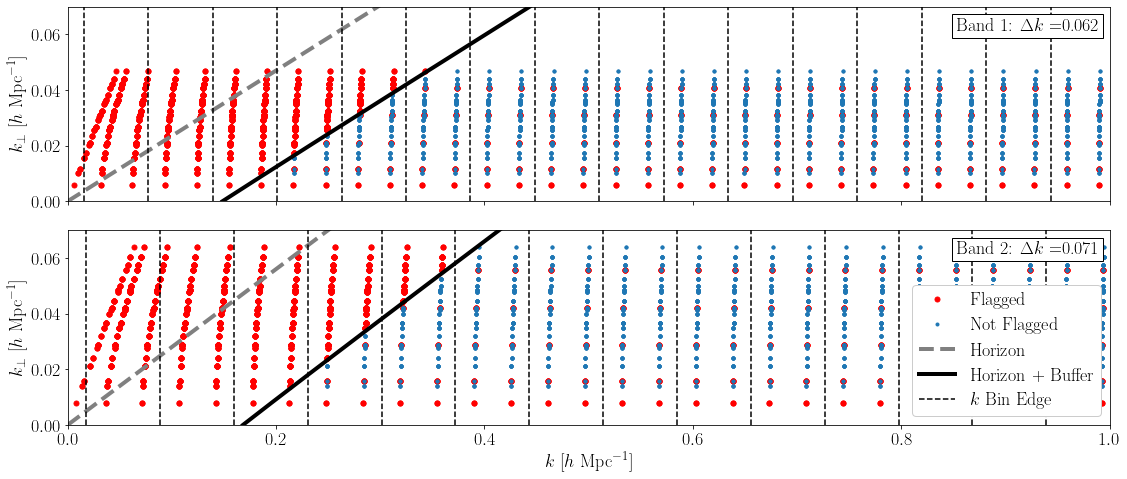

In [48]:
old_binning=False # use the binning parameters for H1C IDR 2.2
field = 2

fig, axes = plt.subplots(2, 1, figsize=(16, 7), sharex=True)
fig.subplots_adjust(wspace=0.03, hspace=0.0)

if old_binning:
    wedge_buffer = 200
    min_ew = 0
else:
    wedge_buffer = wedge_buff_ns
    min_ew = sph_minimum_ew_distance
        
for band, ax in enumerate(axes):
    # keep track of which points are flagged and which ones are not
    kept_k_perps = []
    kept_k_paras = []
    flagged_k_perps = []
    flagged_k_paras = []

    # deepcopy
    u_xtk = copy.deepcopy(uvp_xtk_tavg[field])
    # set P_N for all k_para modes below horizon delay + wedge_buff to large value
    u_xtk.set_stats_slice('P_N', 1e9 / scipy.constants.c, wedge_buffer, above=False, val=np.inf)

    # cut baselines by setting noise to infinity
    for blp, blvec, k_perp in zip(u_xtk.get_blpairs(), u_xtk.get_blpair_blvecs(), u_xtk.get_kperps(band)):
        if not np.any(np.isfinite(u_xtk.get_stats('P_N', (band, blp, ('pI', 'pI'))))):
            continue
            
        cut = False
        if np.linalg.norm(blvec) < sph_minimum_bl_length:
            cut = True
        if np.linalg.norm(blvec) > sph_maximum_bl_length:
            cut = True
        if np.abs(blvec[0]) < min_ew:
            cut = True
        if cut:
            for spw in u_xtk.spw_array:
                for pp in u_xtk.get_polpairs():
                    k = (spw, blp, pp)
                    u_xtk.set_stats('P_N', k, np.ones_like(u_xtk.get_stats('P_N', k)) * np.inf)

        k = (band, blp, pp)
        flags_here = ~np.isfinite(u_xtk.get_stats('P_N', k)).squeeze()
        k_paras = u_xtk.get_kparas(band)
        kept_k_paras.extend(np.abs(k_paras[~flags_here]))
        kept_k_perps.extend(k_perp * np.ones_like(k_paras[~flags_here]))
        flagged_k_paras.extend(np.abs(k_paras[flags_here]))
        flagged_k_perps.extend(k_perp * np.ones_like(k_paras[flags_here]))

    # convert from k_para and k_perp to k
    kept_ks = (np.array(kept_k_perps)**2 + np.array(kept_k_paras)**2)**.5
    flagged_ks = (np.array(flagged_k_perps)**2 + np.array(flagged_k_paras)**2)**.5    
    
    # figure out where the horizon wedge and buffer are
    avgz = uvp.cosmo.f2z(np.mean(u_xtk.freq_array[u_xtk.spw_to_freq_indices(band)]))
    bl_to_kperp = u_xtk.cosmo.bl_to_kperp(avgz)
    tau_to_kpara = u_xtk.cosmo.tau_to_kpara(avgz)
    horizon_taus = np.arange(0, 2000, 1) / 1e9
    horizon_kparas = horizon_taus * tau_to_kpara
    horizon_bls = horizon_taus * constants.c.value
    horizon_kperps = horizon_bls * bl_to_kperp
    horizon_ks = np.sqrt(horizon_kperps**2 + horizon_kparas**2)

    buffer_taus = (wedge_buffer + np.arange(0, 2000, 1)) / 1e9 
    buffer_kparas = buffer_taus * tau_to_kpara
    buffer_ks = np.sqrt(horizon_kperps**2 + buffer_kparas**2)
    
    
    # set dk separately for each band
    dk = dk_multiplier * np.median(np.diff(u_xtk.get_kparas(band)))
    kbins = np.arange(k_start_multiplied * dk, 2.5, dk) # even spacing 
    if old_binning:
        dk = .064
        kbins = np.arange(0, 2.5, dk)
    kbin_edges = kbins - dk / 2
    
    ax.set_xlim([0, 1])
    ax.set_ylim([0, .07])    
    ax.set_ylabel(r'$k_\perp\ [h\ {\rm Mpc}^{-1}$]')    
    ax.plot(flagged_ks, flagged_k_perps, 'r.', ms=10, label='Flagged')
    ax.plot(kept_ks, kept_k_perps, '.', label='Not Flagged')
    ax.plot(horizon_ks, horizon_kperps, '--', lw=4, color='grey', label='Horizon')
    ax.plot(buffer_ks, horizon_kperps, 'k', lw=4, label='Horizon + Buffer')
    for i, edge in enumerate(kbin_edges):
        ax.axvline(edge, color='k', linestyle='--', label=[None, '$k$ Bin Edge'][i==0])    
    ax.text(.99, .066, f'Band {band + 1}: ' + r'$\Delta k$ =' + f'{dk:.3f}', ha='right', va='top', bbox=dict(facecolor='w', alpha=1))
    
    # Show the number of unique baseline delays kept per k bin
    kept_ks_per_bin = []
    for e1, e2 in zip(kbin_edges[:-1], kbin_edges[1:]):
        kept_ks_per_bin.append(int(len(kept_ks[(kept_ks >= e1) & (kept_ks < e2)]) // 2)) # factor of 2 account for positive and negative k_paras
    df = pd.DataFrame({f'Band {band+1}: ' + '$k\ [h\ {Mpc}^{-1}]$': [f'{k:.2f}' for k in kbins[0:int(1//dk)]],
                       'Number of unique-baseline-delays per bin': kept_ks_per_bin[0:int(1//dk)]})
    to_display = df.T.style.set_table_styles([{'selector': 'thead', 'props': [('display', 'none')]}]) \
               .apply(lambda x: ["border-left: 1px solid black" for i, col in enumerate(x)], axis=1) \
               .set_properties(width='40px')
    display(HTML(to_display.render()))
    
axes[1].legend(loc='lower right', framealpha=1)#, title=f'Band {band + 1}')
axes[1].set_xlabel(r'$k\ [h\ {\rm Mpc}^{-1}]$')

plt.tight_layout()
plt.savefig(f'{figures_folder}/{prefix}' + ['spherical_binning.pdf', 'spherical_binning_old.pdf'][old_binning], dpi=200)

## Plot single $\Delta^2(k)$ with window functions

In [49]:
# convert to dsq
uvp_xtk_dsq_1 = []
for u in uvp_xtk_sph_1:
    uvp_xtk_dsq_1.append(u.convert_to_deltasq(inplace=False))
uvp_xtk_dsq_2 = []
for u in uvp_xtk_sph_2:
    uvp_xtk_dsq_2.append(u.convert_to_deltasq(inplace=False))    

divide by zero encountered in true_divide
invalid value encountered in subtract
invalid value encountered in subtract


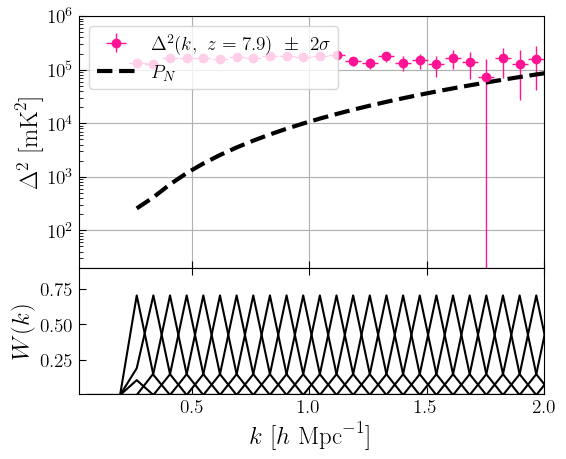

In [50]:
fig = plt.figure(figsize=(6, 5), dpi=100)
fig.subplots_adjust(hspace=0.0)

# set params
plot_window = True
component = 'real'
field = 2 # C

spw = 1
uvp_xtk_dsq = [uvp_xtk_dsq_1, uvp_xtk_dsq_2][spw]
u = uvp_xtk_dsq[fields_used.index(field)]
kp = u.get_kparas(spw)
ks = slice(np.argmin(np.abs(kp - 0.128)), None, 1)
c = 'deeppink'

# get data
y = u.data_array[spw].real.squeeze().copy()[ks].copy()
y[y < 0] *= 0
yerr = np.sqrt(u.cov_array_real[spw].squeeze().diagonal())[ks]
pn = u.stats_array['P_N'][spw].real.squeeze()[ks]
pn[pn <= 0] = np.nan
kbins = u.get_kparas(spw)
k = kbins[ks]
z = u.cosmo.f2z(np.mean(u.get_spw_ranges()[spw][:2]))
xlim = .02, 2

# get x errorbars from window func
x, xerr_low, xerr_hi = sqe.utils.interp_Wcdf(u.window_function_array[spw].squeeze(), kbins)
xerr = np.array([xerr_low, xerr_hi]).T[ks]

grid = gridspec.GridSpec(3, 3)
if plot_window:
    ax = fig.add_subplot(grid[:2, :])
else:
    ax = fig.add_subplot(grid[:, :])

if component == 'abs-real':
    p1 = ax.errorbar(k, np.abs(y), marker='o', ms=6, ls='', yerr=yerr * 2, c=c)
else:
    p1 = ax.errorbar(k, np.real(y), marker='o', ms=6, ls='',
                     yerr=yerr * 2, c=c, xerr=xerr.T, lw=1)

p2, = ax.plot(k, pn, c='k', ls='--', lw=3)

ax.tick_params(labelsize=14, direction='in', size=5)
ax.tick_params(direction='in', size=3, which='minor')
ax.set_yscale('log')
ax.grid()
ax.set_xlim(xlim)
ax.set_ylim(2e1, 1e6)
ax.legend([p1, p2], [r'$\Delta^2(k,\ z={:.1f})\ \pm\ 2\sigma$'.format(z), r'$P_N$'],
          fontsize=14, loc=2, ncol=1)
if not plot_window:
    ax.set_xlabel(r'$k\ [h\ {\rm Mpc}^{-1}$]', fontsize=18)
else:
    ax.set_xticklabels([])
ax.set_ylabel(r'$\Delta^2\ [{\rm mK}^2]$', fontsize=18)

if plot_window:
    ax = fig.add_subplot(grid[2:, :])
    ax.tick_params(labelsize=14, direction='in', size=5, top=True, bottom=True)
    ax.plot(kbins, u.window_function_array[spw].squeeze()[:, ks], c='k', lw=1.5)
    ax.set_xlim(xlim)
    ax.set_ylim(1e-2, 0.9)
    ax.set_xlabel(r'$k\ [h\ {\rm Mpc}^{-1}$]', fontsize=18)
    ax.set_ylabel(r"$W(k)$", fontsize=18)
    #ax.set_yscale('log')
    
#fig.savefig('plots/band2_field1_wf.pdf', dpi=100, bbox_inches='tight')
plt.savefig(f'{figures_folder}/{prefix}limits_band_{spw+1}_field_{"ABCDEFGHIJ"[field]}.png', dpi=200)

## Plot all $\Delta^2(k)$ (real and imaginary)

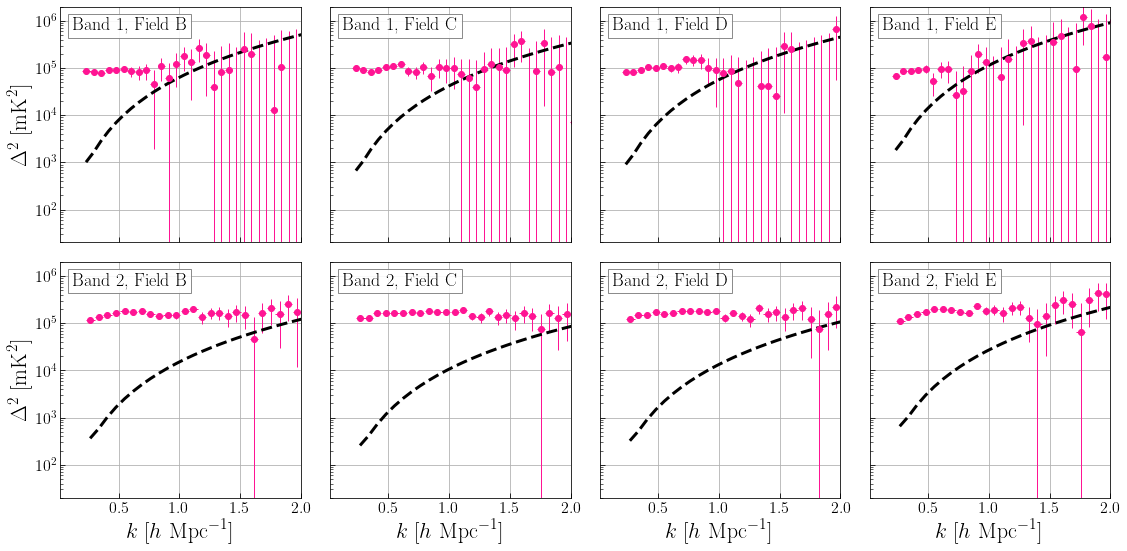

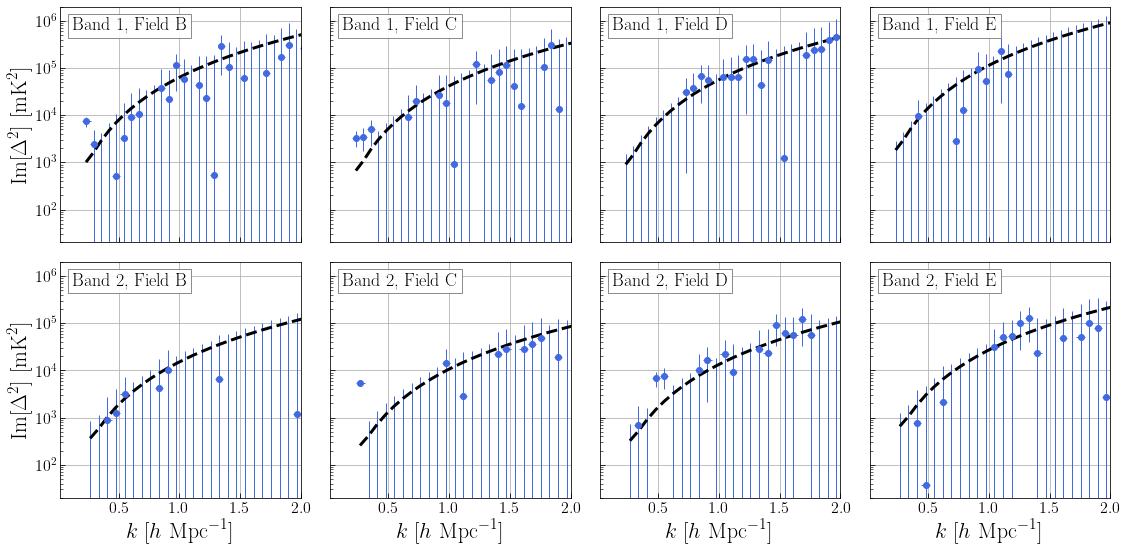

In [51]:
xlim = .02, 2
ylim = 2e1, 2e6

# loop over real and imaginary power spectra
for func, c in [(np.real, 'deeppink'), (np.imag, 'royalblue')]:
    fig, axes = plt.subplots(2, len(uvp_xtk_dsq_1), figsize=(16, 8))
    fig.subplots_adjust(wspace=0.05, hspace=0.05)

    for i in range(2):
        uvp_xtk_dsq = [uvp_xtk_dsq_1, uvp_xtk_dsq_2][i]
        for j in range(len(uvp_xtk_dsq)):
            # get data
            ax = axes[i, j]
            u = uvp_xtk_dsq[j]
            spw = i
            
            # get power spectra and vertical error bars
            y = func(u.data_array[spw].squeeze().copy()[ks].copy())
            y[y < 0] *= 0
            yerr = np.sqrt(np.diagonal(u.cov_array_real[spw].squeeze()))[ks]
            pn = u.stats_array['P_N'][spw].real.squeeze()[ks]
            pn[pn <= 0] = np.nan
            kbins = u.get_kparas(spw)
            k = kbins[ks]
            z = u.cosmo.f2z(np.mean(u.get_spw_ranges()[spw][:2]))       

            # get x errorbars from window func
            x, xerr_low, xerr_hi = sqe.utils.interp_Wcdf(u.window_function_array[spw].squeeze(), kbins)
            xerr = np.array([xerr_low, xerr_hi]).T[ks]
            # plot data
            p1 = ax.errorbar(k, y, marker='o', ms=6, ls='',
                             yerr=yerr * 2, c=c, xerr=xerr.T, lw=1)
            p2, = ax.plot(k, pn, c='k', ls='--', lw=3)

            # handle subplot
            ax.tick_params(labelsize=16, direction='in', size=5)
            ax.tick_params(direction='in', size=3, which='minor')
            ax.set_yscale('log')
            ax.grid()
            ax.set_xlim(xlim)
            ax.set_ylim(ylim)
            ax.text(0.05, 0.9, "Band {}, Field {}".format(i+1, "ABCDEFGHIJ"[fields_used[j]]), fontsize=18,
                    transform=ax.transAxes, bbox=dict(fc='w', ec='grey', alpha=0.9))
            if i == 0:
                ax.set_xticklabels([])
            else:
                ax.set_xlabel(r"$k\ [h\ {\rm Mpc}^{-1}]$", fontsize=22)
            if j == 0:
                if func == np.real:
                    ax.set_ylabel(r"$\Delta^2\ [{\rm mK}^2]$", fontsize=22)
                else:
                    ax.set_ylabel(r"Im$[\Delta^2]\ [{\rm mK}^2]$", fontsize=22)
            else:    
                ax.set_yticklabels([])
    
    plt.tight_layout()
    if func == np.imag:
        plt.savefig(f'{figures_folder}/{prefix}all_imaginary_limits.png', dpi=200)
    else:
        plt.savefig(f'{figures_folder}/{prefix}all_limits.png', dpi=200)

In [52]:
max_k = 1

for spw in [0, 1]:

    uvp_xtk_dsq = [uvp_xtk_dsq_1, uvp_xtk_dsq_2][spw]
    table_created = False
    for field in range(len(uvp_xtk_dsq)):
        ks = uvp_xtk_dsq[field].get_kparas(spw)
        deltasq = uvp_xtk_dsq[field].data_array[spw].squeeze().copy().real
        deltasq_err = np.sqrt(uvp_xtk_dsq[field].cov_array_real[spw].squeeze().diagonal())
        deltasq_ul = np.array([dsq if dsq > 0 else 0 for dsq in deltasq]) + 2 * deltasq_err

        to_use = (ks <= max_k) & (deltasq_err > 0)
        if len(deltasq_ul[to_use]) == 0:
            continue
        
        if not table_created:
            table = np.vstack([deltasq[to_use], deltasq_err[to_use], deltasq_ul[to_use]])
            table_created = True
        else:
            table = np.vstack([table, deltasq[to_use], deltasq_err[to_use], deltasq_ul[to_use]])

    df = pd.DataFrame(table.T)

    col_ix = pd.MultiIndex.from_product([[f'Field {"ABCDEFGHIJ"[field]}' for field in fields_used], 
                                         ['$\Delta^{2}(k)$', '$1\sigma$', '$\Delta^{2}_{UL}$']]) 
    df.columns = col_ix
    df.insert(0, r"$k\ [h\ {\rm Mpc}^{-1}]$", ks[to_use])

    def css_border(x):
        return ["border-left: 1px solid black" if (i%3==1) else "border: 0px" for i, col in enumerate(x)]
    display(HTML(f'<h2>Band {spw+1}:</h2>'))
    
    to_display = df.style.hide_index() \
                   .format("{:,.2f}") \
                   .apply(css_border, axis=1) \
                   .set_properties(width='80px')
    
    display(HTML(to_display.render()))

## Plot all $P(k)$ on a linear scale

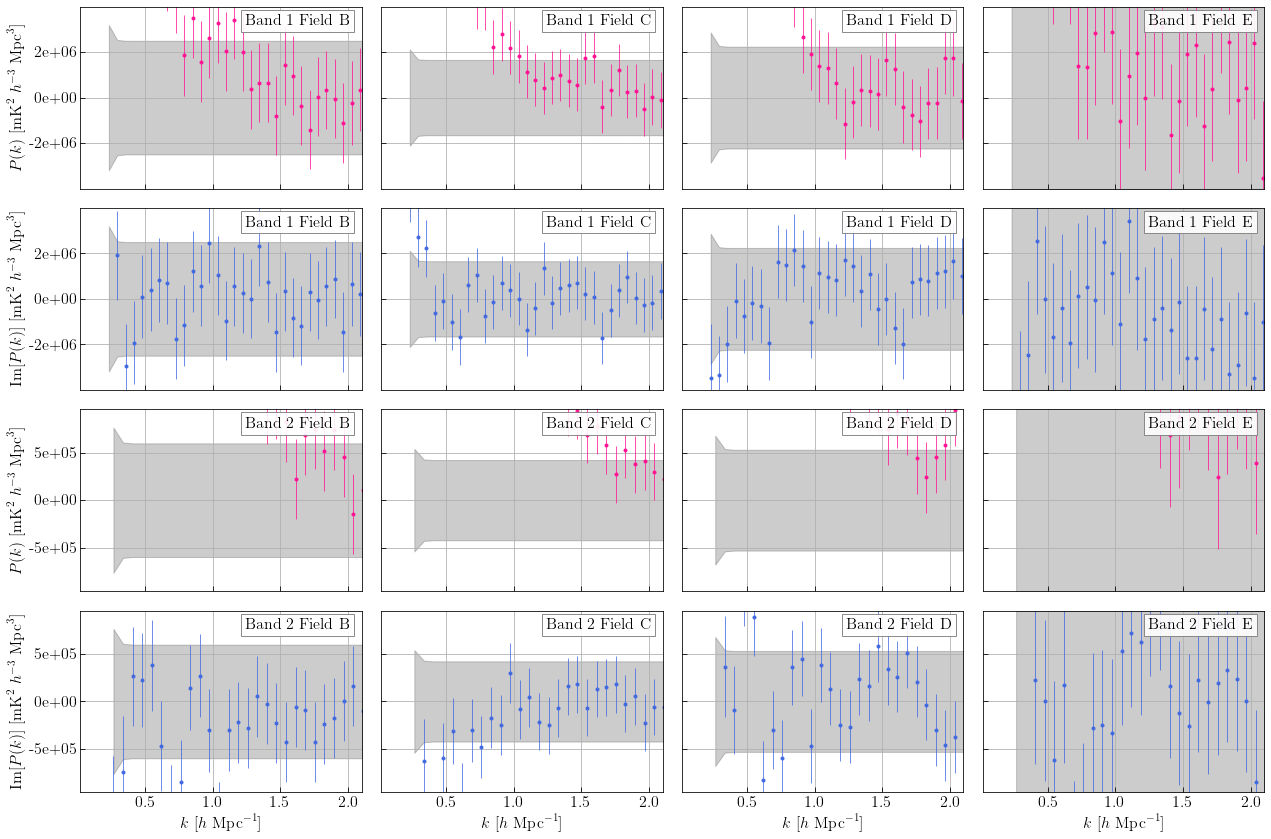

In [53]:
fig, axes = plt.subplots(4, len(uvp_xtk_sph_1), figsize=(18, 12))
fig.subplots_adjust(wspace=0.05, hspace=0.05)

# set params
xlim = .02, 2.1

for i in range(4):
    ylim_set = False
    spw = i // 2
    uvp_xtk_sph = [uvp_xtk_sph_1, uvp_xtk_sph_2][spw]
    for j in range(len(uvp_xtk_sph)):
        # get data
        ax = axes[i, j]
        ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.0e'))
        u = uvp_xtk_sph[j]

        kp = u.get_kparas(spw)
        if i % 2 == 0:
            comp = np.real
            c = 'deeppink'
        else:
            comp = np.imag
            c = 'royalblue'
        y = comp(u.data_array[spw].squeeze().copy()).copy()
        yerr = np.sqrt(np.diagonal(u.cov_array_real[spw].squeeze()))
        pn = u.stats_array['P_N'][spw].real.squeeze()
        k = kp#ks[ks]
        
        # cut out bins with 0 or non-finite errors
        to_use = (pn > 0) | ~np.isfinite(pn)
        y = y[to_use]        
        yerr = yerr[to_use]
        pn = pn[to_use]
        k = k[to_use]
        if len(y) == 0:
            continue
                
        # plot data
        p1 = ax.errorbar(k, y, marker='o', ms=3, ls='',
                         yerr=yerr * 2, c=c, lw=.75)
        ax.fill_between(k, -2*pn, 2*pn, color='k', alpha=0.2, zorder=0)

        # handle subplot
        ax.tick_params(labelsize=16, direction='in', size=5)
        ax.tick_params(direction='in', size=3, which='minor')
        ax.grid()
        ax.set_xlim(xlim)
        if not ylim_set:
            ylim = -np.median(pn[np.isfinite(pn)])*3.2, np.median(pn[np.isfinite(pn)])*3.2
            ylim_set = True
        ax.set_ylim(ylim)
        ax.text(0.96, 0.9, "Band {} Field {}".format((i//2)+1, ("ABCDEFGHIJ"[fields_used[j]])), fontsize=16, ha='right',
                transform=ax.transAxes, bbox=dict(fc='w', ec='grey', alpha=0.9))
        if i < 3:
            ax.set_xticklabels([])
        else:
            ax.set_xlabel(r"$k\ [h\ {\rm Mpc}^{-1}]$", fontsize=16)
        if j == 0:
            if i % 2 == 0:
                ax.set_ylabel(r"$P(k)\ [{\rm mK}^2\ h^{-3}\ {\rm Mpc}^3]$", fontsize=16)
            else:
                ax.set_ylabel(r"Im$[P(k)]\ [{\rm mK}^2\ h^{-3}\ {\rm Mpc}^3]$", fontsize=16)
        else:
            ax.set_yticklabels([])

plt.tight_layout()
plt.savefig(f'{figures_folder}/{prefix}integrated_sph.png', dpi=200)

## Print table of upper limits

In [54]:
max_k = 1

for spw in [0, 1]:

    uvp_xtk_dsq = [uvp_xtk_dsq_1, uvp_xtk_dsq_2][spw]
    table_created = False
    for field in range(len(uvp_xtk_dsq)):
        ks = uvp_xtk_dsq[field].get_kparas(spw)
        deltasq = uvp_xtk_dsq[field].data_array[spw].squeeze().copy().real
        deltasq_err = np.sqrt(uvp_xtk_dsq[field].cov_array_real[spw].squeeze().diagonal())
        deltasq_ul = np.array([dsq if dsq > 0 else 0 for dsq in deltasq]) + 2 * deltasq_err

        to_use = (ks <= max_k) & (deltasq_err > 0)
        if len(deltasq_ul[to_use]) == 0:
            continue
        
        if not table_created:
            table = np.vstack([deltasq[to_use], deltasq_err[to_use], deltasq_ul[to_use]])
            table_created = True
        else:
            table = np.vstack([table, deltasq[to_use], deltasq_err[to_use], deltasq_ul[to_use]])

    df = pd.DataFrame(table.T)

    col_ix = pd.MultiIndex.from_product([[f'Field {"ABCDEFGHIJ"[field]}' for field in fields_used], 
                                         ['$\Delta^{2}(k)$', '$1\sigma$', '$\Delta^{2}_{UL}$']]) 
    df.columns = col_ix
    df.insert(0, r"$k\ [h\ {\rm Mpc}^{-1}]$", ks[to_use])

    def css_border(x):
        return ["border-left: 1px solid black" if (i%3==1) else "border: 0px" for i, col in enumerate(x)]
    display(HTML(f'<h2>Band {spw+1}:</h2>'))
    
    to_display = df.style.hide_index() \
                   .format("{:,.2f}") \
                   .apply(css_border, axis=1) \
                   .set_properties(width='80px')
    
    display(HTML(to_display.render()))

# Save Results

In [55]:
# results are saved to h5 files per-band and per-field
for spw in [0, 1]:
    uvp_xtk_sph = [uvp_xtk_sph_1, uvp_xtk_sph_2][spw]
    uvp_xtk_dsq = [uvp_xtk_dsq_1, uvp_xtk_dsq_2][spw]        
    
    for field in range(len(uvp_xtk_sph)):
        uvp = copy.deepcopy(uvp_xtk_sph[field])
        uvp.select(spws=[spw])
        
        # move on if there's no data here
        ks = uvp.get_kparas(0)
        deltasq_err = np.sqrt(uvp.cov_array_real[0].squeeze().diagonal())
        to_use = (ks <= max_k) & (deltasq_err > 0)
        if len(deltasq_err[to_use]) == 0:
            continue        
        
        # write P(k)
        outfilename = f'{results_folder}/{prefix}Pofk_Band_{spw+1}_Field_{"ABCDEFGHIJ"[fields_used[field]]}.h5'
        uvp.write_hdf5(outfilename, overwrite=True)
        
        # now write Delta sq
        uvp = copy.deepcopy(uvp_xtk_dsq[field])
        uvp.select(spws=[spw])
        outfilename = f'{results_folder}/{prefix}Deltasq_Band_{spw+1}_Field_{"ABCDEFGHIJ"[fields_used[field]]}.h5'
        uvp.write_hdf5(outfilename, overwrite=True)    

results_files/Pofk_Band_1_Field_B.h5 exists, overwriting...
results_files/Deltasq_Band_1_Field_B.h5 exists, overwriting...
results_files/Pofk_Band_1_Field_C.h5 exists, overwriting...
results_files/Deltasq_Band_1_Field_C.h5 exists, overwriting...
results_files/Pofk_Band_1_Field_D.h5 exists, overwriting...
results_files/Deltasq_Band_1_Field_D.h5 exists, overwriting...
results_files/Pofk_Band_1_Field_E.h5 exists, overwriting...
results_files/Deltasq_Band_1_Field_E.h5 exists, overwriting...
results_files/Pofk_Band_2_Field_B.h5 exists, overwriting...
results_files/Deltasq_Band_2_Field_B.h5 exists, overwriting...
results_files/Pofk_Band_2_Field_C.h5 exists, overwriting...
results_files/Deltasq_Band_2_Field_C.h5 exists, overwriting...
results_files/Pofk_Band_2_Field_D.h5 exists, overwriting...
results_files/Deltasq_Band_2_Field_D.h5 exists, overwriting...
results_files/Pofk_Band_2_Field_E.h5 exists, overwriting...
results_files/Deltasq_Band_2_Field_E.h5 exists, overwriting...
